In [1]:
import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype
#import pyarrow.feather as feather
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
import pytorch_tabnet
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier
import torch


from sklearn.model_selection import KFold, cross_val_score

# import xgboost as xgb
import optuna
from optuna import Trial, visualization



# Convert to classification task

In [2]:

# grouped_data["Success_Rates"] = 10 * grouped_data["Success_Rates"]
# grouped_data['Success_Rates'] = grouped_data['Success_Rates'].astype(np.int64)
# grouped_data = grouped_data.mul({'Success_Rates': 10}, axis='columns')
# grouped_data.to_csv('6dof_classification.csv')

grouped_data = pd.read_csv('6dof_classification.csv')
grouped_data = grouped_data.drop(columns='Unnamed: 0')
grouped_data


,Link2 length,Link3 length,Link4 length,Link5 length,Link6 length,Success_Rates,Joint2 type_pitch,Joint2 type_pris,Joint2 type_roll,Joint3 type_pitch,...,Joint3 axis_z,Joint4 axis_x,Joint4 axis_y,Joint4 axis_z,Joint5 axis_x,Joint5 axis_y,Joint5 axis_z,Joint6 axis_x,Joint6 axis_y,Joint6 axis_z
0,0.1,0.1,0.1,0.3,0.7,0,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
1,0.1,0.1,0.1,0.5,0.5,0,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
2,0.1,0.1,0.1,0.7,0.7,0,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
3,0.1,0.1,0.1,0.7,0.7,0,1,0,0,1,...,0,1,0,0,1,0,0,0,1,0
4,0.1,0.1,0.1,0.7,0.7,0,1,0,0,1,...,0,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102535,0.7,0.7,0.3,0.1,0.1,2,0,0,1,0,...,0,0,1,0,1,0,0,0,0,1
102536,0.7,0.7,0.1,0.1,0.3,7,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
102537,0.7,0.7,0.3,0.1,0.1,0,0,0,1,0,...,0,0,0,1,0,1,0,1,0,0
102538,0.7,0.7,0.1,0.1,0.3,10,0,0,1,0,...,0,0,1,0,0,1,0,1,0,0


In [205]:
X = grouped_data.loc[:,grouped_data.columns != 'Success_Rates']
Y = grouped_data.loc[:,grouped_data.columns == 'Success_Rates']
X=X.to_numpy()
X = [[float(j) for j in i] for i in X]
X=np.array(X)
Y=Y.to_numpy()



x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.25, random_state=2)
    
    
print("x train\n", x_train.shape)
print("y train\n", y_train.shape)

print("x valid\n", x_valid.shape)
print("y valid\n", y_valid.shape)

print("x test\n", x_test.shape)
print("y test\n", y_test.shape)


x train
 (61524, 34)
y train
 (61524, 1)
x valid
 (20508, 34)
y valid
 (20508, 1)
x test
 (20508, 34)
y test
 (20508, 1)


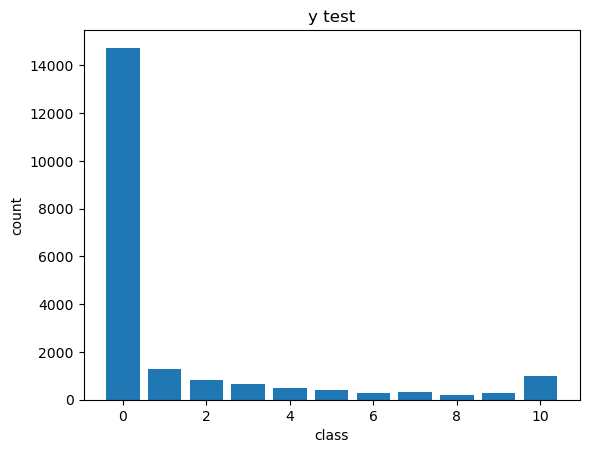

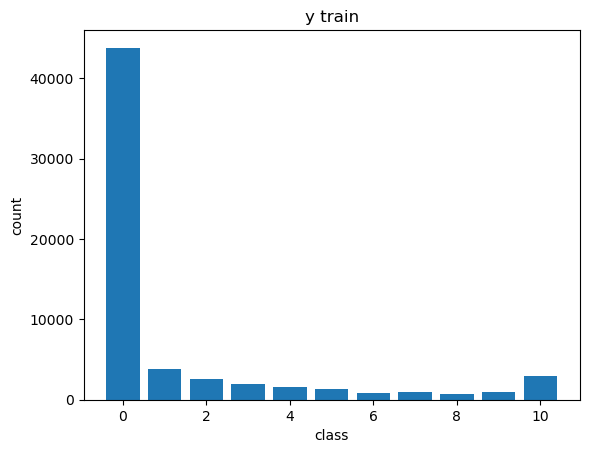

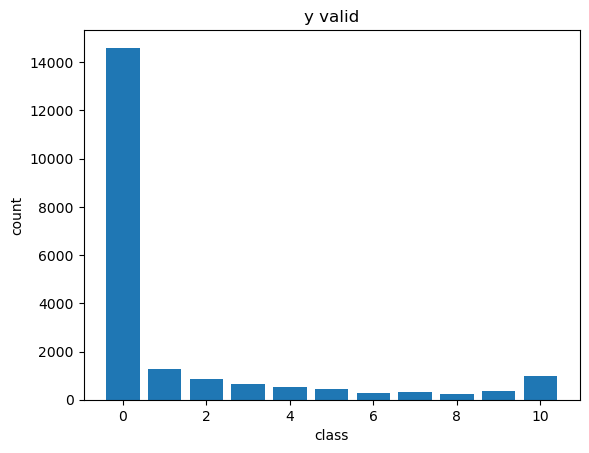

a (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([14736,  1283,   841,   651,   504,   397,   287,   305,   212,
         301,   991]))
b (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([43820,  3872,  2606,  1897,  1587,  1292,   832,   922,   699,
        1018,  2979]))
c (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([14603,  1263,   857,   650,   520,   454,   278,   302,   233,
         344,  1004]))


In [206]:
# a = np.squeeze(y_test)==5
# unique, counts = np.unique(a, return_counts=True)

# dict(zip(unique, counts))
a = np.unique(np.squeeze(y_test), return_counts=True)
plt.bar(x=a[0],height=a[1])
plt.title('y test')
plt.xlabel('class')
plt.ylabel('count')
plt.show()

b = np.unique(np.squeeze(y_train), return_counts=True)
plt.bar(x=b[0],height=b[1])
plt.title('y train')
plt.xlabel('class')
plt.ylabel('count')

plt.show()

c = np.unique(np.squeeze(y_valid), return_counts=True)
plt.bar(x=c[0],height=c[1])
plt.title('y valid')
plt.xlabel('class')
plt.ylabel('count')
plt.show()

print('a',a)
print('b',b)
print('c',c)



In [207]:
clf = TabNetMultiTaskClassifier(n_steps=1,
                                optimizer_fn=torch.optim.Adam,
                                optimizer_params=dict(lr=2e-2),
                                scheduler_params={"step_size":50, # how to use learning rate scheduler
                                                  "gamma":0.9},
                                scheduler_fn=torch.optim.lr_scheduler.StepLR,
                                mask_type='entmax', # "sparsemax",
                                lambda_sparse=0, # don't penalize for sparser attention
                       
                      )


Device used : cpu


In [208]:
max_epochs = 1000
clf.fit(
    X_train=x_train, y_train=y_train,
    eval_set=[(x_valid, y_valid)],
    eval_metric=['accuracy'],
    max_epochs=max_epochs ,
    patience=50, # please be patient ^^
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=1,
    drop_last=False,
)

epoch 0  | loss: 1.29292 | val_0_accuracy: 0.71206 |  0:00:01s
epoch 1  | loss: 1.15628 | val_0_accuracy: 0.71206 |  0:00:02s
epoch 2  | loss: 1.09688 | val_0_accuracy: 0.7187  |  0:00:04s
epoch 3  | loss: 1.05574 | val_0_accuracy: 0.7206  |  0:00:05s
epoch 4  | loss: 1.04045 | val_0_accuracy: 0.72396 |  0:00:06s
epoch 5  | loss: 1.02342 | val_0_accuracy: 0.7263  |  0:00:07s
epoch 6  | loss: 1.01742 | val_0_accuracy: 0.72898 |  0:00:09s
epoch 7  | loss: 1.0063  | val_0_accuracy: 0.7302  |  0:00:10s
epoch 8  | loss: 0.99697 | val_0_accuracy: 0.73025 |  0:00:11s
epoch 9  | loss: 0.99455 | val_0_accuracy: 0.73206 |  0:00:12s
epoch 10 | loss: 0.98777 | val_0_accuracy: 0.7322  |  0:00:13s
epoch 11 | loss: 0.9843  | val_0_accuracy: 0.73069 |  0:00:14s
epoch 12 | loss: 0.97665 | val_0_accuracy: 0.73176 |  0:00:15s
epoch 13 | loss: 0.97255 | val_0_accuracy: 0.73181 |  0:00:17s
epoch 14 | loss: 0.97127 | val_0_accuracy: 0.73254 |  0:00:18s
epoch 15 | loss: 0.96897 | val_0_accuracy: 0.73401 |  0

epoch 131| loss: 0.87797 | val_0_accuracy: 0.74078 |  0:02:32s
epoch 132| loss: 0.87673 | val_0_accuracy: 0.7383  |  0:02:33s
epoch 133| loss: 0.87841 | val_0_accuracy: 0.73981 |  0:02:35s
epoch 134| loss: 0.87532 | val_0_accuracy: 0.74039 |  0:02:36s
epoch 135| loss: 0.87858 | val_0_accuracy: 0.74049 |  0:02:37s
epoch 136| loss: 0.87908 | val_0_accuracy: 0.74147 |  0:02:38s
epoch 137| loss: 0.8766  | val_0_accuracy: 0.73996 |  0:02:39s
epoch 138| loss: 0.88083 | val_0_accuracy: 0.74171 |  0:02:41s
epoch 139| loss: 0.87627 | val_0_accuracy: 0.74005 |  0:02:42s
epoch 140| loss: 0.87773 | val_0_accuracy: 0.74108 |  0:02:43s
epoch 141| loss: 0.87395 | val_0_accuracy: 0.73996 |  0:02:45s
epoch 142| loss: 0.87892 | val_0_accuracy: 0.74142 |  0:02:46s
epoch 143| loss: 0.8777  | val_0_accuracy: 0.74152 |  0:02:47s
epoch 144| loss: 0.87866 | val_0_accuracy: 0.74083 |  0:02:48s
epoch 145| loss: 0.8726  | val_0_accuracy: 0.742   |  0:02:49s
epoch 146| loss: 0.87839 | val_0_accuracy: 0.74074 |  0

epoch 262| loss: 0.85623 | val_0_accuracy: 0.74308 |  0:05:10s
epoch 263| loss: 0.85882 | val_0_accuracy: 0.74332 |  0:05:12s
epoch 264| loss: 0.85901 | val_0_accuracy: 0.74303 |  0:05:13s
epoch 265| loss: 0.85883 | val_0_accuracy: 0.74225 |  0:05:14s
epoch 266| loss: 0.85547 | val_0_accuracy: 0.74249 |  0:05:15s
epoch 267| loss: 0.85933 | val_0_accuracy: 0.74293 |  0:05:16s
epoch 268| loss: 0.85522 | val_0_accuracy: 0.74337 |  0:05:18s
epoch 269| loss: 0.85648 | val_0_accuracy: 0.74239 |  0:05:19s
epoch 270| loss: 0.8585  | val_0_accuracy: 0.74366 |  0:05:20s
epoch 271| loss: 0.8551  | val_0_accuracy: 0.74332 |  0:05:21s
epoch 272| loss: 0.85715 | val_0_accuracy: 0.74342 |  0:05:22s
epoch 273| loss: 0.85578 | val_0_accuracy: 0.74127 |  0:05:23s
epoch 274| loss: 0.85712 | val_0_accuracy: 0.74249 |  0:05:24s
epoch 275| loss: 0.85582 | val_0_accuracy: 0.74283 |  0:05:26s
epoch 276| loss: 0.85717 | val_0_accuracy: 0.7421  |  0:05:27s
epoch 277| loss: 0.85645 | val_0_accuracy: 0.74059 |  0

Text(0.5, 1.0, 'loss')

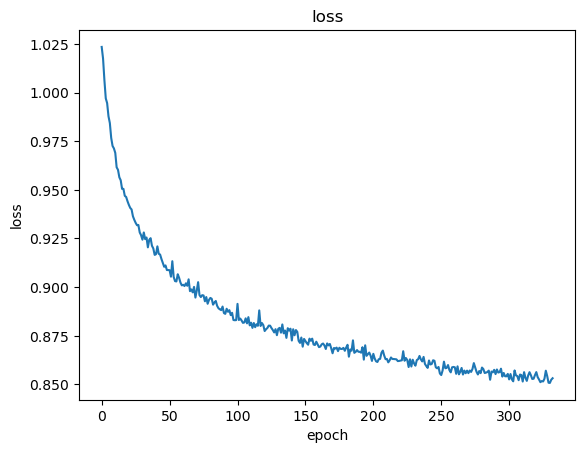

In [209]:
plt.plot(clf.history['loss'][5:])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss')
# plt.plot(clf.history['valid']['loss'][5:])

Text(0.5, 1.0, 'validation accuracy')

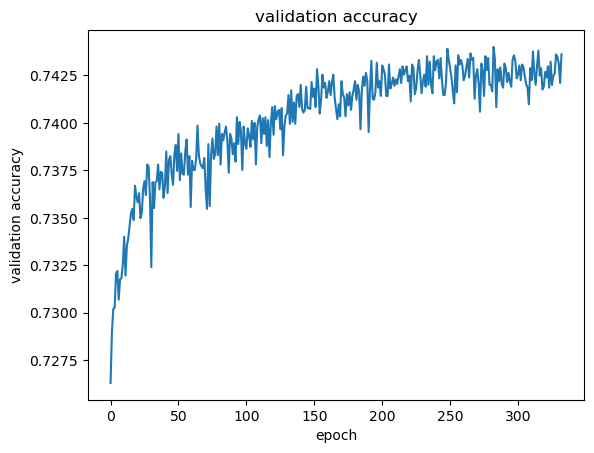

In [210]:
plt.plot(clf.history['val_0_accuracy'][5:])
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.title('validation accuracy')

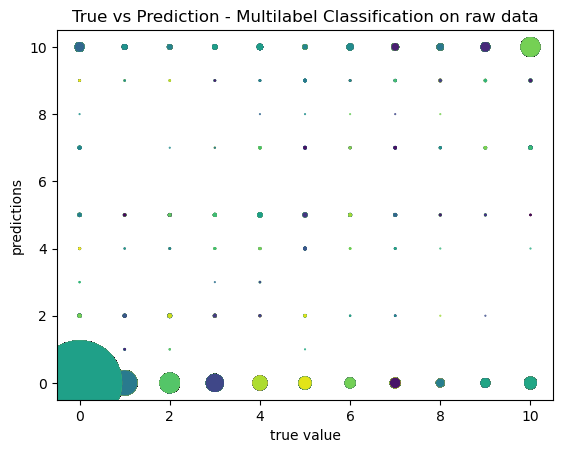

In [211]:
preds = clf.predict(x_test) 
from sklearn.metrics import accuracy_score
# accuracy = accuracy_score(y_test,preds)

# print(f"Accuracy SCORE: {accuracy}")
# print(f"MSE TEST SCORE: {test_mse}")
# print(f"RMSE TEST SCORE: {test_rmse}")
# print(f"MAE TEST SCORE: {test_mae}")

# from sklearn.metrics import r2_score
# score = r2_score(y_test, preds)
# print(score)
# print("The accuracy of our model is {}%".format(round(score, 2) *100))

# y_test
df = pd.DataFrame(preds)
dft = df.T
dft.columns = ['preds']
dft['preds'] = dft['preds'].apply(pd.to_numeric)
dft1= dft.loc[dft['preds'] > 0]
dft = dft.to_numpy()
y_test
colors = np.random.rand(20508)

from collections import Counter
c = Counter(zip(y_test[:, 0],dft[:, 0]))
# create a list of the sizes, here multiplied by 10 for scale
s = [(c[(xx,yy)]/4) for xx,yy in zip(y_test[:, 0],dft[:, 0])]

plt.scatter(x=y_test[:, 0],y=dft[:, 0], s=s,c =colors)
plt.xlabel('true value')
plt.ylabel('predictions')
plt.title('True vs Prediction - Multilabel Classification on raw data')
# To show the plot
plt.show()



Text(0, 0.5, 'count')

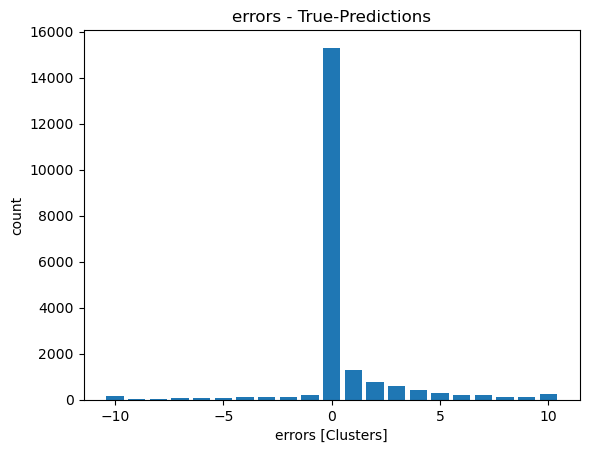

In [212]:
errors  = y_test[:, 0] - dft[:, 0]
# residuals

# plt.hist(errors, align='left',color='g',bins='auto', range = (-10,10),edgecolor='b',linewidth=1)
# plt.title('errors - True-Predictions')
# plt.xlabel('errors')
# plt.ylabel('Frequency')

error_df = pd.DataFrame(errors, columns=["error"])
error_df

amount = [error_df['error'].loc[error_df['error']==-10].count(),
          error_df['error'].loc[error_df['error']==-9].count(),
          error_df['error'].loc[error_df['error']==-8].count(),
        error_df['error'].loc[error_df['error']==-7].count(),
         error_df['error'].loc[error_df['error']==-6].count(),
          error_df['error'].loc[error_df['error']==-5].count(),
         error_df['error'].loc[error_df['error']==-4].count(),
         error_df['error'].loc[error_df['error']==-3].count(),
         error_df['error'].loc[error_df['error']==-2].count(),
         error_df['error'].loc[error_df['error']==-1].count(),
         error_df['error'].loc[error_df['error']==0].count(),
         error_df['error'].loc[error_df['error']==1].count(),
          error_df['error'].loc[error_df['error']==2].count(),
        error_df['error'].loc[error_df['error']==3].count(),
         error_df['error'].loc[error_df['error']==4].count(),
          error_df['error'].loc[error_df['error']==5].count(),
         error_df['error'].loc[error_df['error']==6].count(),
         error_df['error'].loc[error_df['error']==7].count(),
         error_df['error'].loc[error_df['error']==8].count(),
         error_df['error'].loc[error_df['error']==9].count(),
         error_df['error'].loc[error_df['error']==10].count()]
data = {'clusters error':[*range(-10, 11, 1)],'amount':amount}
df = pd.DataFrame(data)

plt.bar(x=df['clusters error'],height=df['amount'])
plt.title('errors - True-Predictions')
plt.xlabel('errors [Clusters]')
plt.ylabel('count')

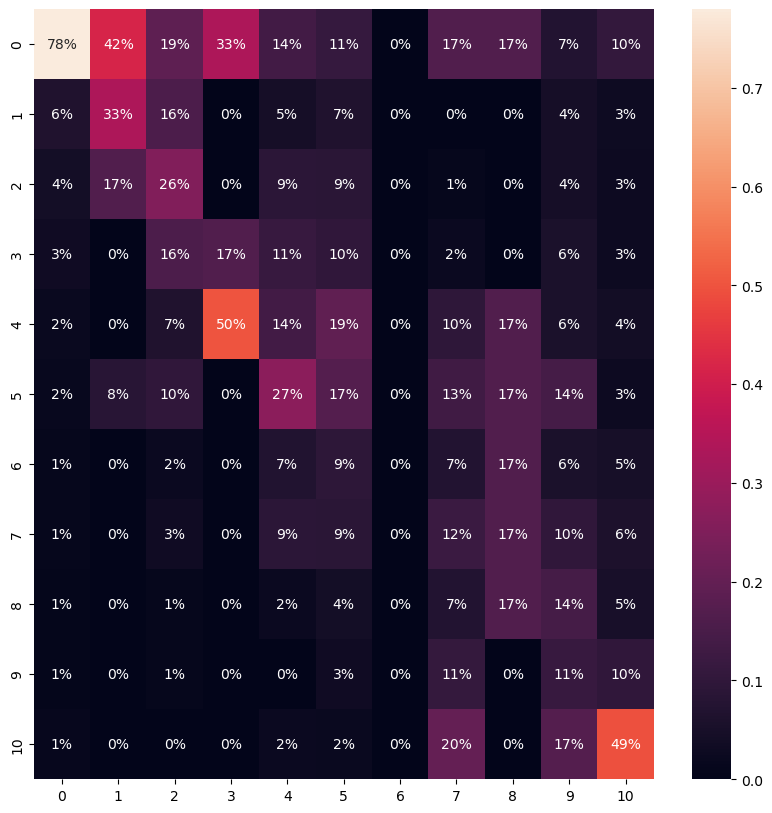

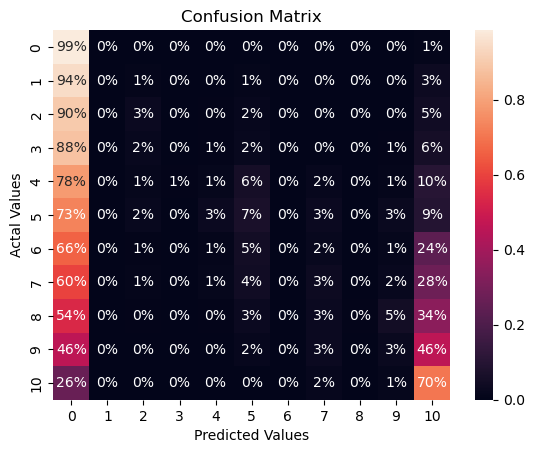

In [218]:
from sklearn.metrics import confusion_matrix
np.set_printoptions()
cm = confusion_matrix(y_test[:, 0],dft[:, 0])
cm_df = pd.DataFrame(cm,
                     index = ['0','1','2','3','4','5','6','7','8','9','10'], 
                     columns = ['0','1','2','3','4','5','6','7','8','9','10'])

plt.figure(figsize=(10,10))

cm_perc=(cm_df/np.sum(cm_df)).fillna(0)
cm_perc

sns.heatmap(cm_perc, annot=True,fmt='.0%')
plt.show()

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True,fmt='.0%')

plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()


# Balanced: 0 / bigger than 0

In [3]:
no_sucsses = grouped_data.loc[grouped_data['Success_Rates']==0]
yes_sucsses = grouped_data.loc[grouped_data['Success_Rates']>0]
yes_sucsses

,Link2 length,Link3 length,Link4 length,Link5 length,Link6 length,Success_Rates,Joint2 type_pitch,Joint2 type_pris,Joint2 type_roll,Joint3 type_pitch,...,Joint3 axis_z,Joint4 axis_x,Joint4 axis_y,Joint4 axis_z,Joint5 axis_x,Joint5 axis_y,Joint5 axis_z,Joint6 axis_x,Joint6 axis_y,Joint6 axis_z
10,0.1,0.1,0.1,0.5,0.5,1,1,0,0,1,...,0,1,0,0,0,1,0,0,0,1
15,0.1,0.1,0.1,0.7,0.5,1,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
23,0.1,0.1,0.3,0.7,0.1,2,1,0,0,1,...,0,1,0,0,0,0,1,0,1,0
34,0.1,0.1,0.5,0.5,0.7,3,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
47,0.1,0.1,0.5,0.5,0.1,1,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102534,0.7,0.7,0.1,0.1,0.3,10,0,0,1,0,...,0,0,1,0,0,0,1,0,1,0
102535,0.7,0.7,0.3,0.1,0.1,2,0,0,1,0,...,0,0,1,0,1,0,0,0,0,1
102536,0.7,0.7,0.1,0.1,0.3,7,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
102538,0.7,0.7,0.1,0.1,0.3,10,0,0,1,0,...,0,0,1,0,0,1,0,1,0,0


In [4]:
N_sucsses =no_sucsses.sample(29381)
grouped_data1 = pd.concat([yes_sucsses,N_sucsses]).reset_index(drop=True)
grouped_data_shuffled = grouped_data1.sample(frac=1).reset_index(drop=True)
grouped_data_shuffled

,Link2 length,Link3 length,Link4 length,Link5 length,Link6 length,Success_Rates,Joint2 type_pitch,Joint2 type_pris,Joint2 type_roll,Joint3 type_pitch,...,Joint3 axis_z,Joint4 axis_x,Joint4 axis_y,Joint4 axis_z,Joint5 axis_x,Joint5 axis_y,Joint5 axis_z,Joint6 axis_x,Joint6 axis_y,Joint6 axis_z
0,0.3,0.5,0.3,0.1,0.1,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,1
1,0.3,0.3,0.1,0.7,0.1,2,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
2,0.1,0.3,0.5,0.7,0.1,0,0,1,0,1,...,0,0,1,0,0,0,1,0,1,0
3,0.3,0.1,0.3,0.7,0.1,0,0,1,0,1,...,0,1,0,0,1,0,0,1,0,0
4,0.7,0.3,0.1,0.1,0.1,0,0,1,0,0,...,0,0,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58757,0.7,0.1,0.1,0.3,0.3,3,0,1,0,0,...,1,0,1,0,0,1,0,0,1,0
58758,0.1,0.1,0.5,0.5,0.1,0,0,0,1,0,...,1,0,1,0,0,1,0,0,1,0
58759,0.3,0.1,0.5,0.1,0.3,5,0,1,0,1,...,1,0,0,1,0,0,1,0,1,0
58760,0.7,0.1,0.3,0.5,0.1,5,1,0,0,0,...,0,0,1,0,0,0,1,0,1,0


In [5]:
X = grouped_data_shuffled.loc[:,grouped_data_shuffled.columns != 'Success_Rates']
Y = grouped_data_shuffled.loc[:,grouped_data_shuffled.columns == 'Success_Rates']
X=X.to_numpy()
X = [[float(j) for j in i] for i in X]
X=np.array(X)
Y=Y.to_numpy()



x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.25, random_state=2)
    
    
print("x train\n", x_train.shape)
print("y train\n", y_train.shape)

print("x valid\n", x_valid.shape)
print("y valid\n", y_valid.shape)

print("x test\n", x_test.shape)
print("y test\n", y_test.shape)


x train
 (35256, 34)
y train
 (35256, 1)
x valid
 (11753, 34)
y valid
 (11753, 1)
x test
 (11753, 34)
y test
 (11753, 1)


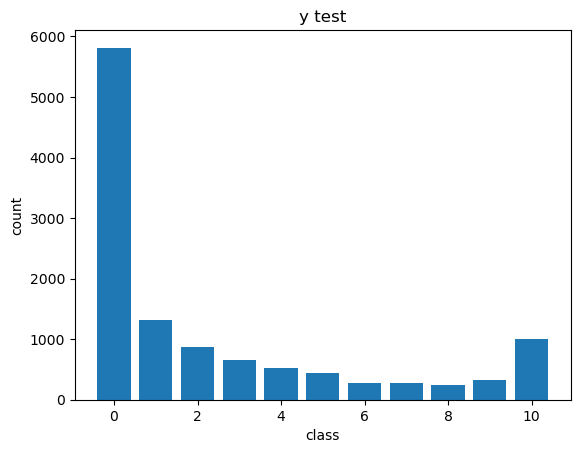

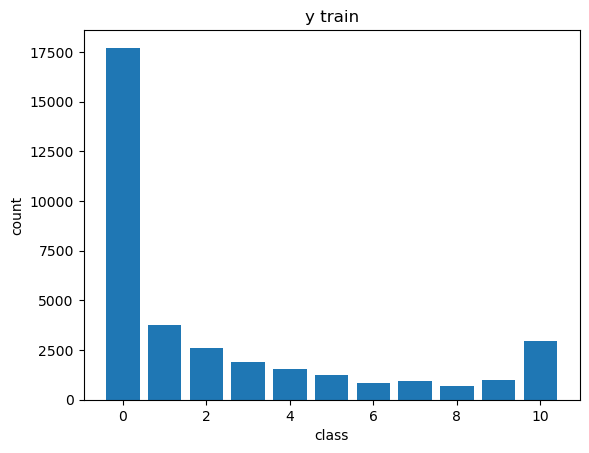

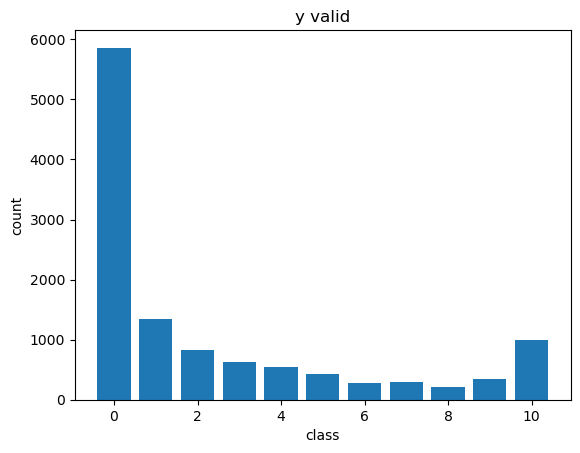

a (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([5814, 1324,  864,  657,  524,  449,  273,  283,  236,  321, 1008]))
b (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([17707,  3757,  2609,  1916,  1535,  1267,   846,   948,   699,
        1001,  2971]))
c (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([5860, 1337,  831,  625,  552,  427,  278,  298,  209,  341,  995]))


In [6]:
a = np.unique(np.squeeze(y_test), return_counts=True)
plt.bar(x=a[0],height=a[1])
plt.title('y test')
plt.xlabel('class')
plt.ylabel('count')
plt.show()

b = np.unique(np.squeeze(y_train), return_counts=True)
plt.bar(x=b[0],height=b[1])
plt.title('y train')
plt.xlabel('class')
plt.ylabel('count')

plt.show()

c = np.unique(np.squeeze(y_valid), return_counts=True)
plt.bar(x=c[0],height=c[1])
plt.title('y valid')
plt.xlabel('class')
plt.ylabel('count')
plt.show()

print('a',a)
print('b',b)
print('c',c)

In [7]:
clf = TabNetMultiTaskClassifier(n_steps=1,
                                optimizer_fn=torch.optim.Adam,
                                optimizer_params=dict(lr=2e-2),
                                scheduler_params={"step_size":50, # how to use learning rate scheduler
                                                  "gamma":0.9},
                                scheduler_fn=torch.optim.lr_scheduler.StepLR,
                                mask_type='entmax', # "sparsemax",
                                lambda_sparse=0, # don't penalize for sparser attention
                       
                      )

Device used : cpu


In [8]:
max_epochs = 1000
clf.fit(
    X_train=x_train, y_train=y_train,
    eval_set=[(x_valid, y_valid)],
    eval_metric=['accuracy'],
    max_epochs=max_epochs ,
    patience=50, # please be patient ^^
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=1,
    drop_last=False,
)

epoch 0  | loss: 1.85799 | val_0_accuracy: 0.4986  |  0:00:00s
epoch 1  | loss: 1.70169 | val_0_accuracy: 0.4986  |  0:00:01s
epoch 2  | loss: 1.62895 | val_0_accuracy: 0.49885 |  0:00:01s
epoch 3  | loss: 1.5807  | val_0_accuracy: 0.50549 |  0:00:02s
epoch 4  | loss: 1.53707 | val_0_accuracy: 0.51442 |  0:00:03s
epoch 5  | loss: 1.51279 | val_0_accuracy: 0.51502 |  0:00:04s
epoch 6  | loss: 1.49753 | val_0_accuracy: 0.5214  |  0:00:04s
epoch 7  | loss: 1.47777 | val_0_accuracy: 0.52821 |  0:00:05s
epoch 8  | loss: 1.47097 | val_0_accuracy: 0.5328  |  0:00:06s
epoch 9  | loss: 1.46088 | val_0_accuracy: 0.53927 |  0:00:06s
epoch 10 | loss: 1.4511  | val_0_accuracy: 0.5368  |  0:00:07s
epoch 11 | loss: 1.44514 | val_0_accuracy: 0.54182 |  0:00:08s
epoch 12 | loss: 1.43258 | val_0_accuracy: 0.54361 |  0:00:08s
epoch 13 | loss: 1.42531 | val_0_accuracy: 0.54327 |  0:00:09s
epoch 14 | loss: 1.4224  | val_0_accuracy: 0.5442  |  0:00:10s
epoch 15 | loss: 1.41358 | val_0_accuracy: 0.54514 |  0

epoch 131| loss: 1.2566  | val_0_accuracy: 0.56113 |  0:01:29s
epoch 132| loss: 1.26067 | val_0_accuracy: 0.5613  |  0:01:30s
epoch 133| loss: 1.25889 | val_0_accuracy: 0.56292 |  0:01:31s
epoch 134| loss: 1.25384 | val_0_accuracy: 0.56156 |  0:01:32s
epoch 135| loss: 1.25849 | val_0_accuracy: 0.56105 |  0:01:32s
epoch 136| loss: 1.25671 | val_0_accuracy: 0.56122 |  0:01:33s
epoch 137| loss: 1.25993 | val_0_accuracy: 0.56369 |  0:01:34s
epoch 138| loss: 1.25739 | val_0_accuracy: 0.55986 |  0:01:34s
epoch 139| loss: 1.25815 | val_0_accuracy: 0.56181 |  0:01:35s
epoch 140| loss: 1.25499 | val_0_accuracy: 0.56096 |  0:01:36s
epoch 141| loss: 1.2524  | val_0_accuracy: 0.56292 |  0:01:36s
epoch 142| loss: 1.2543  | val_0_accuracy: 0.56181 |  0:01:37s
epoch 143| loss: 1.26157 | val_0_accuracy: 0.56386 |  0:01:38s
epoch 144| loss: 1.25894 | val_0_accuracy: 0.56326 |  0:01:38s
epoch 145| loss: 1.25207 | val_0_accuracy: 0.56403 |  0:01:39s
epoch 146| loss: 1.25439 | val_0_accuracy: 0.55867 |  0

Text(0.5, 1.0, 'validation accuracy')

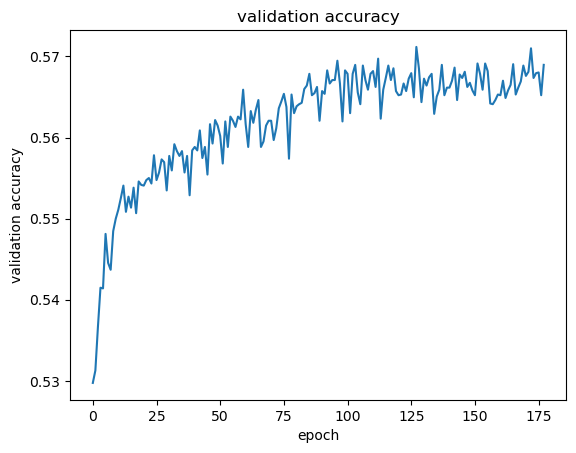

In [225]:
plt.plot(clf.history['val_0_accuracy'][5:])
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.title('validation accuracy')

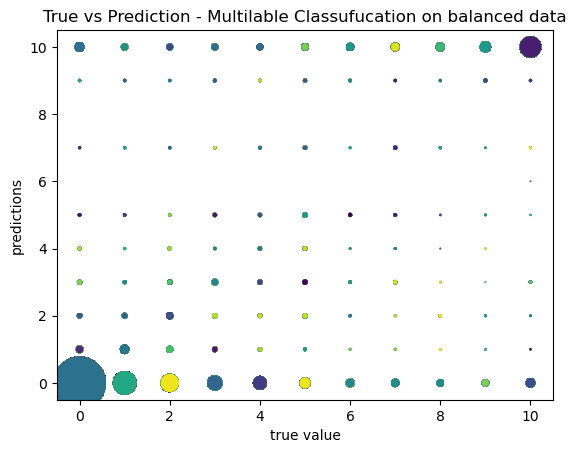

In [9]:
preds = clf.predict(x_test) 
from sklearn.metrics import accuracy_score
# accuracy = accuracy_score(y_test,preds)

# print(f"Accuracy SCORE: {accuracy}")
# print(f"MSE TEST SCORE: {test_mse}")
# print(f"RMSE TEST SCORE: {test_rmse}")
# print(f"MAE TEST SCORE: {test_mae}")

# from sklearn.metrics import r2_score
# score = r2_score(y_test, preds)
# print(score)
# print("The accuracy of our model is {}%".format(round(score, 2) *100))

# y_test
df = pd.DataFrame(preds)
dft = df.T
dft.columns = ['preds']
dft['preds'] = dft['preds'].apply(pd.to_numeric)
dft1= dft.loc[dft['preds'] > 0]
dft = dft.to_numpy()
y_test
colors = np.random.rand(11753)

from collections import Counter
c = Counter(zip(y_test[:, 0],dft[:, 0]))
# create a list of the sizes, here multiplied by 10 for scale
s = [(c[(xx,yy)]/4) for xx,yy in zip(y_test[:, 0],dft[:, 0])]


plt.scatter(y_test[:, 0],dft[:, 0],s=s, c =colors)
plt.xlabel('true value')
plt.ylabel('predictions')
plt.title('True vs Prediction - Multilable Classufucation on balanced data')
# To show the plot
plt.show()

0

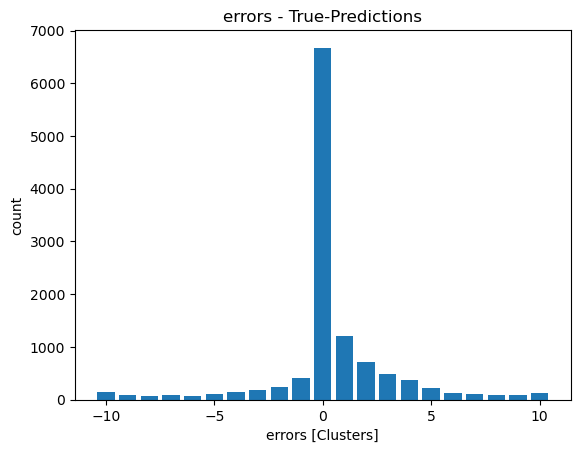

In [10]:
errors  = y_test[:, 0] - dft[:, 0]
# residuals

# plt.hist(errors, align='left',color='g', edgecolor='b',linewidth=1)
# plt.xlabel('Residuals: y_true-preds')
# plt.ylabel('Frequency')

error_df = pd.DataFrame(errors, columns=["error"])
error_df

amount = [error_df['error'].loc[error_df['error']==-10].count(),
          error_df['error'].loc[error_df['error']==-9].count(),
          error_df['error'].loc[error_df['error']==-8].count(),
        error_df['error'].loc[error_df['error']==-7].count(),
         error_df['error'].loc[error_df['error']==-6].count(),
          error_df['error'].loc[error_df['error']==-5].count(),
         error_df['error'].loc[error_df['error']==-4].count(),
         error_df['error'].loc[error_df['error']==-3].count(),
         error_df['error'].loc[error_df['error']==-2].count(),
         error_df['error'].loc[error_df['error']==-1].count(),
         error_df['error'].loc[error_df['error']==0].count(),
         error_df['error'].loc[error_df['error']==1].count(),
          error_df['error'].loc[error_df['error']==2].count(),
        error_df['error'].loc[error_df['error']==3].count(),
         error_df['error'].loc[error_df['error']==4].count(),
          error_df['error'].loc[error_df['error']==5].count(),
         error_df['error'].loc[error_df['error']==6].count(),
         error_df['error'].loc[error_df['error']==7].count(),
         error_df['error'].loc[error_df['error']==8].count(),
         error_df['error'].loc[error_df['error']==9].count(),
         error_df['error'].loc[error_df['error']==10].count()]
data = {'clusters error':[*range(-10, 11, 1)],'amount':amount}
df = pd.DataFrame(data)

plt.bar(x=df['clusters error'],height=df['amount'])
plt.title('errors - True-Predictions')
plt.xlabel('errors [Clusters]')
plt.ylabel('count')

error_df['error'].loc[error_df['error']<-10].count()

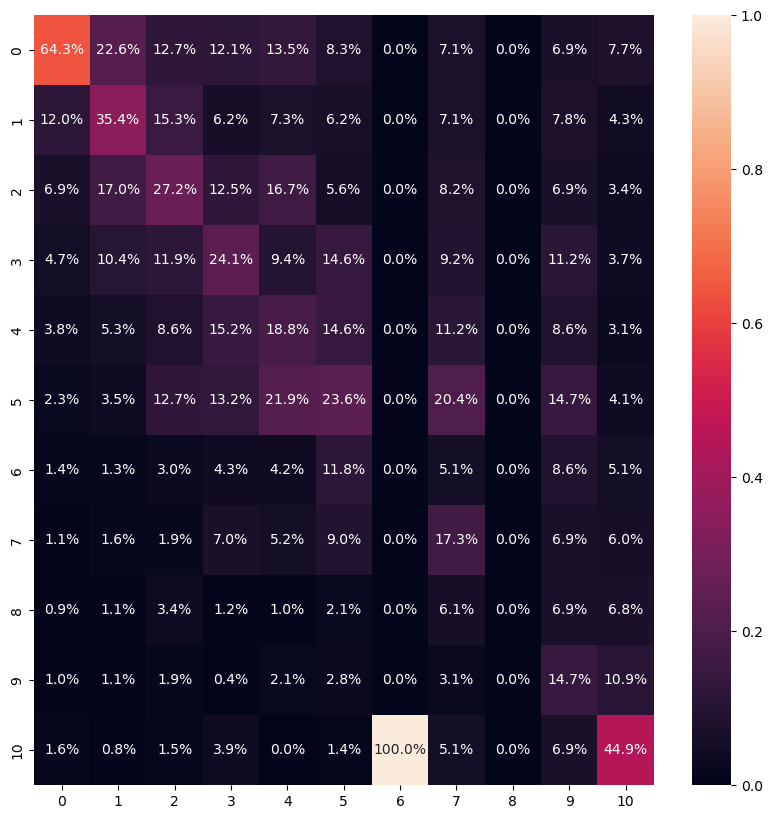

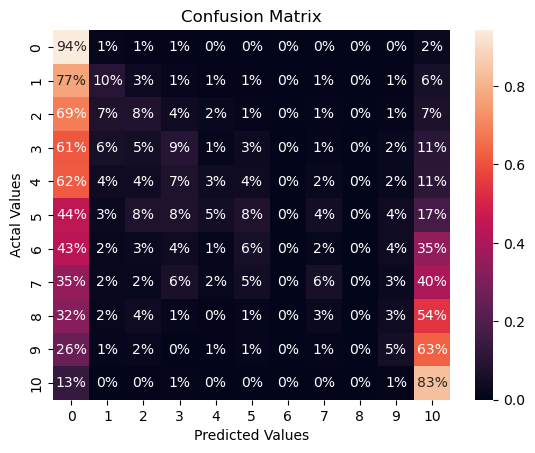

In [11]:
from sklearn.metrics import confusion_matrix
np.set_printoptions()
cm = confusion_matrix(y_test[:, 0],dft[:, 0])
cm_df = pd.DataFrame(cm,
                     index = ['0','1','2','3','4','5','6','7','8','9','10'], 
                     columns = ['0','1','2','3','4','5','6','7','8','9','10'])

plt.figure(figsize=(10,10))
cm_perc=(cm_df/np.sum(cm_df)).fillna(0)
cm_perc

sns.heatmap(cm_perc, annot=True,fmt='.1%')
plt.show()

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True,fmt='.0%')

plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

# Bin Balanced - by smallest bin

In [12]:
grouped_data['Success_Rates'].value_counts()

0     73159
1      6418
10     4974
2      4304
3      3198
4      2611
5      2143
9      1663
7      1529
6      1397
8      1144
Name: Success_Rates, dtype: int64

In [13]:
sucsses_0 = grouped_data.loc[grouped_data['Success_Rates']==0].sample(1144, ignore_index=True)
sucsses_1 = grouped_data.loc[grouped_data['Success_Rates']==1].sample(1144, ignore_index=True)
sucsses_2 = grouped_data.loc[grouped_data['Success_Rates']==2].sample(1144, ignore_index=True)
sucsses_3 = grouped_data.loc[grouped_data['Success_Rates']==3].sample(1144, ignore_index=True)
sucsses_4 = grouped_data.loc[grouped_data['Success_Rates']==4].sample(1144, ignore_index=True)
sucsses_5 = grouped_data.loc[grouped_data['Success_Rates']==5].sample(1144, ignore_index=True)
sucsses_6 = grouped_data.loc[grouped_data['Success_Rates']==6].sample(1144, ignore_index=True)
sucsses_7 = grouped_data.loc[grouped_data['Success_Rates']==7].sample(1144, ignore_index=True)
sucsses_8 = grouped_data.loc[grouped_data['Success_Rates']==8]
sucsses_9 = grouped_data.loc[grouped_data['Success_Rates']==9].sample(1144, ignore_index=True)
sucsses_10 = grouped_data.loc[grouped_data['Success_Rates']==10].sample(1144, ignore_index=True)

grouped_data2 = pd.concat([sucsses_0,sucsses_1,sucsses_2,sucsses_3,sucsses_4,sucsses_5,sucsses_6,
                           sucsses_7,sucsses_8,sucsses_9,sucsses_10]).reset_index(drop=True)
grouped_data_shuffled2 = grouped_data2.sample(frac=1).reset_index(drop=True)
grouped_data_shuffled2


,Link2 length,Link3 length,Link4 length,Link5 length,Link6 length,Success_Rates,Joint2 type_pitch,Joint2 type_pris,Joint2 type_roll,Joint3 type_pitch,...,Joint3 axis_z,Joint4 axis_x,Joint4 axis_y,Joint4 axis_z,Joint5 axis_x,Joint5 axis_y,Joint5 axis_z,Joint6 axis_x,Joint6 axis_y,Joint6 axis_z
0,0.3,0.7,0.3,0.1,0.1,7,0,1,0,1,...,0,0,0,1,0,0,1,0,1,0
1,0.1,0.1,0.3,0.5,0.3,2,1,0,0,1,...,1,0,0,1,1,0,0,0,0,1
2,0.5,0.3,0.1,0.3,0.3,7,0,1,0,1,...,1,0,1,0,0,1,0,0,1,0
3,0.1,0.7,0.3,0.1,0.1,6,1,0,0,0,...,0,0,0,1,0,0,1,1,0,0
4,0.3,0.1,0.5,0.3,0.1,1,1,0,0,1,...,0,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12579,0.5,0.5,0.3,0.1,0.3,4,0,1,0,0,...,0,0,0,1,0,1,0,0,0,1
12580,0.5,0.3,0.1,0.3,0.3,3,0,1,0,1,...,0,0,0,1,0,0,1,0,0,1
12581,0.3,0.3,0.3,0.1,0.3,7,0,1,0,1,...,0,0,0,1,1,0,0,0,1,0
12582,0.3,0.3,0.7,0.5,0.1,1,1,0,0,0,...,0,0,1,0,0,0,1,0,1,0


In [14]:
X = grouped_data_shuffled2.loc[:,grouped_data_shuffled2.columns != 'Success_Rates']
Y = grouped_data_shuffled2.loc[:,grouped_data_shuffled2.columns == 'Success_Rates']
X=X.to_numpy()
X = [[float(j) for j in i] for i in X]
X=np.array(X)
Y=Y.to_numpy()



x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.25, random_state=2)
    
    
print("x train\n", x_train.shape)
print("y train\n", y_train.shape)

print("x valid\n", x_valid.shape)
print("y valid\n", y_valid.shape)

print("x test\n", x_test.shape)
print("y test\n", y_test.shape)

x train
 (7550, 34)
y train
 (7550, 1)
x valid
 (2517, 34)
y valid
 (2517, 1)
x test
 (2517, 34)
y test
 (2517, 1)


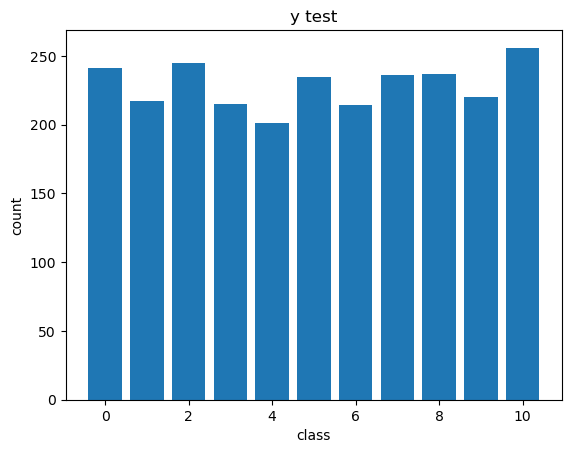

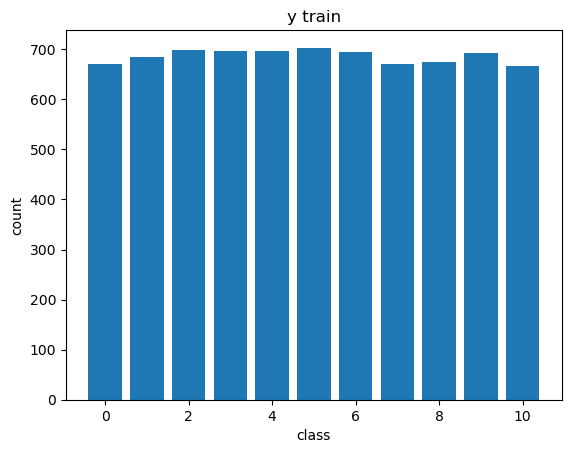

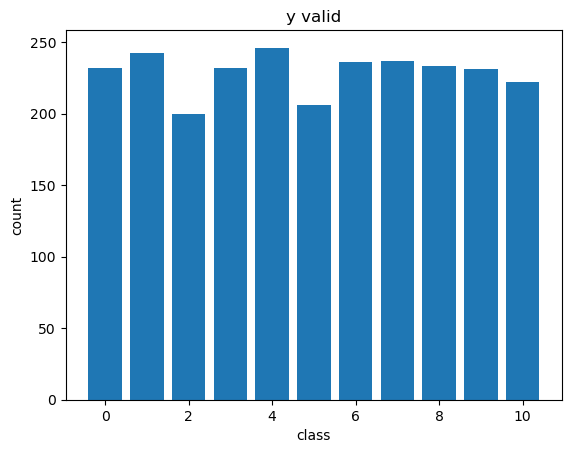

a (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([241, 217, 245, 215, 201, 235, 214, 236, 237, 220, 256]))
b (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([671, 685, 699, 697, 697, 703, 694, 671, 674, 693, 666]))
c (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([232, 242, 200, 232, 246, 206, 236, 237, 233, 231, 222]))


In [15]:
a = np.unique(np.squeeze(y_test), return_counts=True)
plt.bar(x=a[0],height=a[1])
plt.title('y test')
plt.xlabel('class')
plt.ylabel('count')
plt.show()

b = np.unique(np.squeeze(y_train), return_counts=True)
plt.bar(x=b[0],height=b[1])
plt.title('y train')
plt.xlabel('class')
plt.ylabel('count')

plt.show()

c = np.unique(np.squeeze(y_valid), return_counts=True)
plt.bar(x=c[0],height=c[1])
plt.title('y valid')
plt.xlabel('class')
plt.ylabel('count')
plt.show()

print('a',a)
print('b',b)
print('c',c)

In [16]:
clf = TabNetMultiTaskClassifier(n_steps=1,
                                optimizer_fn=torch.optim.Adam,
                                optimizer_params=dict(lr=2e-2),
                                scheduler_params={"step_size":50, # how to use learning rate scheduler
                                                  "gamma":0.9},
                                scheduler_fn=torch.optim.lr_scheduler.StepLR,
                                mask_type='entmax', # "sparsemax",
                                lambda_sparse=0, # don't penalize for sparser attention
                       
                      )

Device used : cpu


In [17]:
max_epochs = 1000
clf.fit(
    X_train=x_train, y_train=y_train,
    eval_set=[(x_valid, y_valid)],
    eval_metric=['accuracy'],
    max_epochs=max_epochs ,
    patience=50, # please be patient ^^
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=1,
    drop_last=False,
)

epoch 0  | loss: 2.48172 | val_0_accuracy: 0.09813 |  0:00:00s
epoch 1  | loss: 2.39427 | val_0_accuracy: 0.09853 |  0:00:00s
epoch 2  | loss: 2.39135 | val_0_accuracy: 0.10369 |  0:00:00s
epoch 3  | loss: 2.38604 | val_0_accuracy: 0.10648 |  0:00:01s
epoch 4  | loss: 2.37852 | val_0_accuracy: 0.1025  |  0:00:01s
epoch 5  | loss: 2.36811 | val_0_accuracy: 0.10807 |  0:00:01s
epoch 6  | loss: 2.35571 | val_0_accuracy: 0.11005 |  0:00:01s
epoch 7  | loss: 2.34226 | val_0_accuracy: 0.11522 |  0:00:02s
epoch 8  | loss: 2.32605 | val_0_accuracy: 0.12555 |  0:00:02s
epoch 9  | loss: 2.30995 | val_0_accuracy: 0.13389 |  0:00:02s
epoch 10 | loss: 2.29681 | val_0_accuracy: 0.12912 |  0:00:02s
epoch 11 | loss: 2.27913 | val_0_accuracy: 0.14462 |  0:00:03s
epoch 12 | loss: 2.2618  | val_0_accuracy: 0.13548 |  0:00:03s
epoch 13 | loss: 2.25009 | val_0_accuracy: 0.15296 |  0:00:03s
epoch 14 | loss: 2.23573 | val_0_accuracy: 0.14104 |  0:00:03s
epoch 15 | loss: 2.22417 | val_0_accuracy: 0.14859 |  0

epoch 131| loss: 1.82838 | val_0_accuracy: 0.19031 |  0:00:35s
epoch 132| loss: 1.83734 | val_0_accuracy: 0.19309 |  0:00:35s

Early stopping occurred at epoch 132 with best_epoch = 82 and best_val_0_accuracy = 0.2054
Best weights from best epoch are automatically used!


Text(0.5, 1.0, 'validation accuracy')

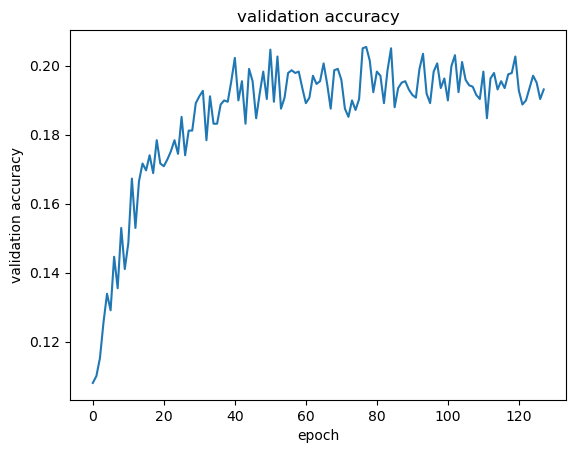

In [18]:
plt.plot(clf.history['val_0_accuracy'][5:])
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.title('validation accuracy')

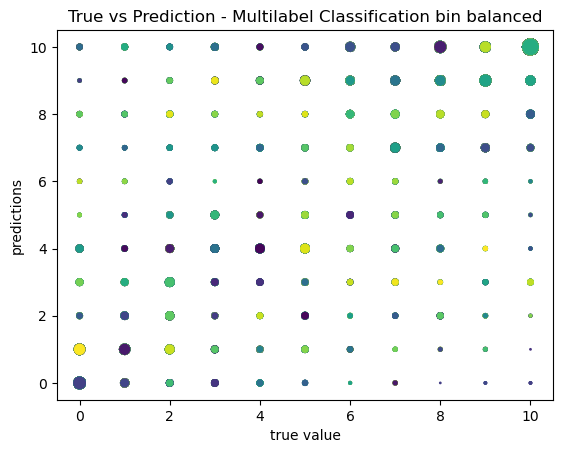

In [19]:
preds = clf.predict(x_test) 
from sklearn.metrics import accuracy_score
# accuracy = accuracy_score(y_test,preds)

# print(f"Accuracy SCORE: {accuracy}")
# print(f"MSE TEST SCORE: {test_mse}")
# print(f"RMSE TEST SCORE: {test_rmse}")
# print(f"MAE TEST SCORE: {test_mae}")

# from sklearn.metrics import r2_score
# score = r2_score(y_test, preds)
# print(score)
# print("The accuracy of our model is {}%".format(round(score, 2) *100))

# y_test
df = pd.DataFrame(preds)
dft = df.T
dft.columns = ['preds']
dft['preds'] = dft['preds'].apply(pd.to_numeric)
dft1= dft.loc[dft['preds'] > 0]
dft = dft.to_numpy()
y_test
colors = np.random.rand(2517)

from collections import Counter
c = Counter(zip(y_test[:, 0],dft[:, 0]))
# create a list of the sizes, here multiplied by 10 for scale
s = [(c[(xx,yy)]) for xx,yy in zip(y_test[:, 0],dft[:, 0])]


plt.scatter(y_test[:, 0],dft[:, 0],s=s, c =colors)
plt.xlabel('true value')
plt.ylabel('predictions')
plt.title('True vs Prediction - Multilabel Classification bin balanced')
# To show the plot
plt.show()

Text(0, 0.5, 'count')

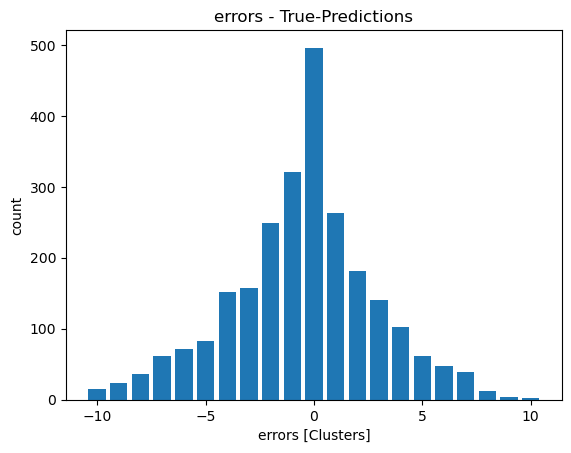

In [20]:
residuals  = y_test[:, 0] - dft[:, 0]
# residuals

# plt.hist(residuals, align='left',color='g', edgecolor='b',linewidth=1)
# plt.xlabel('Residuals: y_true-preds')
# plt.ylabel('Frequency')
error_df = pd.DataFrame(residuals, columns=["error"])
error_df

amount = [error_df['error'].loc[error_df['error']==-10].count(),
          error_df['error'].loc[error_df['error']==-9].count(),
          error_df['error'].loc[error_df['error']==-8].count(),
        error_df['error'].loc[error_df['error']==-7].count(),
         error_df['error'].loc[error_df['error']==-6].count(),
          error_df['error'].loc[error_df['error']==-5].count(),
         error_df['error'].loc[error_df['error']==-4].count(),
         error_df['error'].loc[error_df['error']==-3].count(),
         error_df['error'].loc[error_df['error']==-2].count(),
         error_df['error'].loc[error_df['error']==-1].count(),
         error_df['error'].loc[error_df['error']==0].count(),
         error_df['error'].loc[error_df['error']==1].count(),
          error_df['error'].loc[error_df['error']==2].count(),
        error_df['error'].loc[error_df['error']==3].count(),
         error_df['error'].loc[error_df['error']==4].count(),
          error_df['error'].loc[error_df['error']==5].count(),
         error_df['error'].loc[error_df['error']==6].count(),
         error_df['error'].loc[error_df['error']==7].count(),
         error_df['error'].loc[error_df['error']==8].count(),
         error_df['error'].loc[error_df['error']==9].count(),
         error_df['error'].loc[error_df['error']==10].count()]
data = {'clusters error':[*range(-10, 11, 1)],'amount':amount}
df = pd.DataFrame(data)

plt.bar(x=df['clusters error'],height=df['amount'])
plt.title('errors - True-Predictions')
plt.xlabel('errors [Clusters]')
plt.ylabel('count')


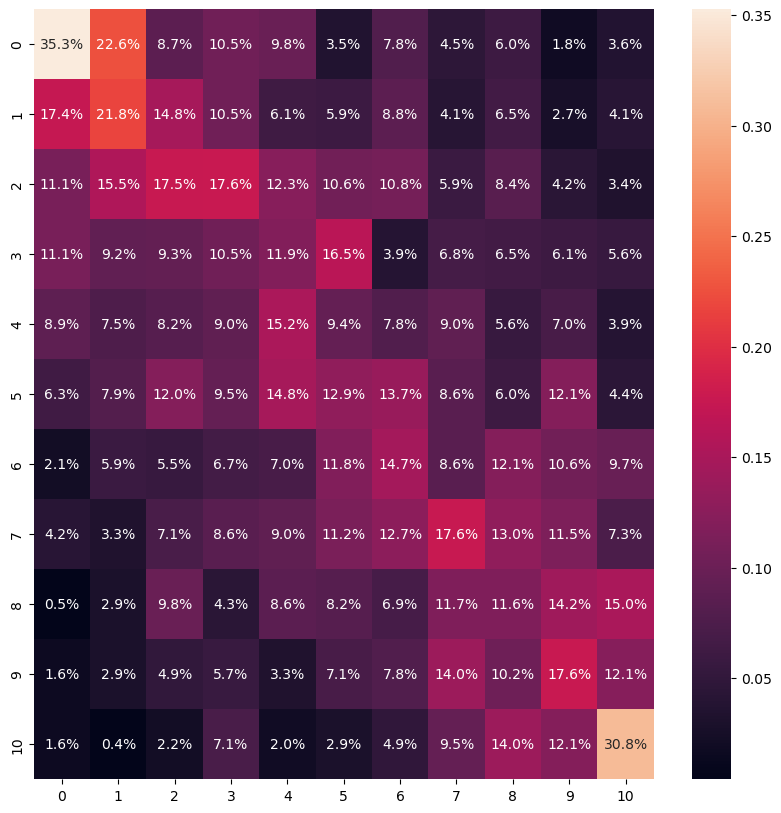

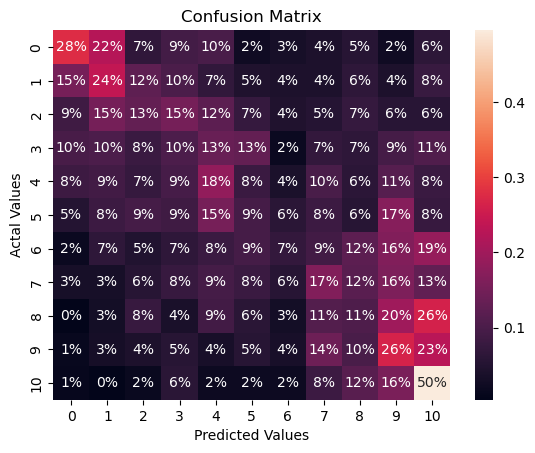

In [21]:
# from sklearn.metrics import confusion_matrix
# np.set_printoptions()
# cm = confusion_matrix(y_test[:, 0],dft[:, 0])
# cm_df = pd.DataFrame(cm,
#                      index = ['0','1','2','3','4','5','6','7','8','9','10'], 
#                      columns = ['0','1','2','3','4','5','6','7','8','9','10'])

# plt.figure(figsize=(10,10))
# cm_perc=(cm_df/np.sum(cm_df)).fillna(0)
# cm_perc

# sns.heatmap(cm_perc, annot=True,fmt='.1%')
# plt.title('Confusion Matrix')
# plt.ylabel('Actal Values')
# plt.xlabel('Predicted Values')
# plt.show()

from sklearn.metrics import confusion_matrix
np.set_printoptions()
cm = confusion_matrix(y_test[:, 0],dft[:, 0])
cm_df = pd.DataFrame(cm,
                     index = ['0','1','2','3','4','5','6','7','8','9','10'], 
                     columns = ['0','1','2','3','4','5','6','7','8','9','10'])

plt.figure(figsize=(10,10))
cm_perc=(cm_df/np.sum(cm_df)).fillna(0)
cm_perc
sns.heatmap(cm_perc, annot=True,fmt='.1%')
plt.show()

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True,fmt='.0%')


plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

# 90% from each bin

In [241]:
grouped_data['Success_Rates'].value_counts()

0     73159
1      6418
10     4974
2      4304
3      3198
4      2611
5      2143
9      1663
7      1529
6      1397
8      1144
Name: Success_Rates, dtype: int64

In [242]:
sucsses_0 = grouped_data.loc[grouped_data['Success_Rates']==0].sample(int(73159*0.9), ignore_index=True)
sucsses_1 = grouped_data.loc[grouped_data['Success_Rates']==1].sample(int(6418*0.9), ignore_index=True)
sucsses_2 = grouped_data.loc[grouped_data['Success_Rates']==2].sample(int(4304*0.9), ignore_index=True)
sucsses_3 = grouped_data.loc[grouped_data['Success_Rates']==3].sample(int(3198*0.9), ignore_index=True)
sucsses_4 = grouped_data.loc[grouped_data['Success_Rates']==4].sample(int(2611*0.9), ignore_index=True)
sucsses_5 = grouped_data.loc[grouped_data['Success_Rates']==5].sample(int(2143*0.9), ignore_index=True)
sucsses_6 = grouped_data.loc[grouped_data['Success_Rates']==6].sample(int(1397*0.9), ignore_index=True)
sucsses_7 = grouped_data.loc[grouped_data['Success_Rates']==7].sample(int(1529*0.9), ignore_index=True)
sucsses_8 = grouped_data.loc[grouped_data['Success_Rates']==8].sample(int(1144*0.9), ignore_index=True)
sucsses_9 = grouped_data.loc[grouped_data['Success_Rates']==9].sample(int(1663*0.9), ignore_index=True)
sucsses_10 = grouped_data.loc[grouped_data['Success_Rates']==10].sample(int(4974*0.9), ignore_index=True)

grouped_data3 = pd.concat([sucsses_0,sucsses_1,sucsses_2,sucsses_3,sucsses_4,sucsses_5,sucsses_6,
                           sucsses_7,sucsses_8,sucsses_9,sucsses_10]).reset_index(drop=True)
grouped_data_shuffled3 = grouped_data3.sample(frac=1).reset_index(drop=True)
grouped_data_shuffled3

,Link2 length,Link3 length,Link4 length,Link5 length,Link6 length,Success_Rates,Joint2 type_pitch,Joint2 type_pris,Joint2 type_roll,Joint3 type_pitch,...,Joint3 axis_z,Joint4 axis_x,Joint4 axis_y,Joint4 axis_z,Joint5 axis_x,Joint5 axis_y,Joint5 axis_z,Joint6 axis_x,Joint6 axis_y,Joint6 axis_z
0,0.1,0.7,0.3,0.3,0.3,10,1,0,0,1,...,0,1,0,0,0,0,1,1,0,0
1,0.1,0.3,0.1,0.7,0.3,0,0,0,1,0,...,0,0,1,0,1,0,0,0,1,0
2,0.3,0.3,0.1,0.1,0.7,0,0,1,0,0,...,0,0,1,0,0,1,0,0,1,0
3,0.1,0.3,0.1,0.1,0.7,0,1,0,0,1,...,0,0,1,0,1,0,0,0,1,0
4,0.1,0.7,0.3,0.3,0.3,0,0,1,0,0,...,0,0,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92276,0.7,0.3,0.1,0.1,0.3,0,1,0,0,1,...,1,1,0,0,0,1,0,0,1,0
92277,0.3,0.1,0.1,0.7,0.5,0,1,0,0,0,...,0,0,0,1,1,0,0,0,1,0
92278,0.3,0.3,0.7,0.1,0.5,1,1,0,0,1,...,1,1,0,0,0,1,0,0,1,0
92279,0.7,0.3,0.1,0.1,0.5,3,0,1,0,1,...,1,0,0,1,0,0,1,0,1,0


In [243]:
X = grouped_data_shuffled3.loc[:,grouped_data_shuffled3.columns != 'Success_Rates']
Y = grouped_data_shuffled3.loc[:,grouped_data_shuffled3.columns == 'Success_Rates']
X=X.to_numpy()
X = [[float(j) for j in i] for i in X]
X=np.array(X)
Y=Y.to_numpy()



x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.25, random_state=2)
    
    
print("x train\n", x_train.shape)
print("y train\n", y_train.shape)

print("x valid\n", x_valid.shape)
print("y valid\n", y_valid.shape)

print("x test\n", x_test.shape)
print("y test\n", y_test.shape)

x train
 (55368, 34)
y train
 (55368, 1)
x valid
 (18456, 34)
y valid
 (18456, 1)
x test
 (18457, 34)
y test
 (18457, 1)


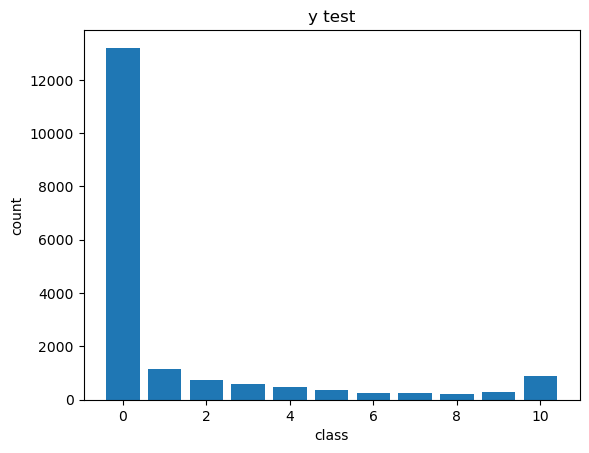

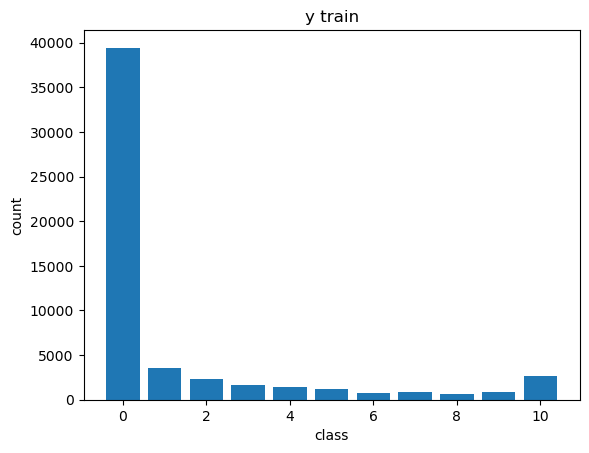

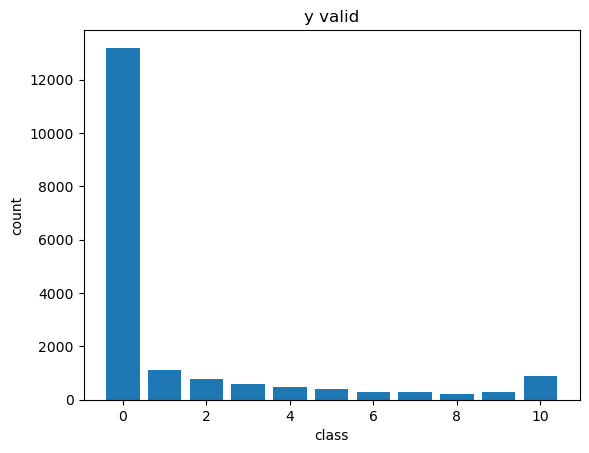

a (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([13204,  1138,   746,   606,   492,   367,   259,   254,   204,
         304,   883]))
b (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([39440,  3515,  2366,  1696,  1386,  1173,   710,   841,   624,
         906,  2711]))
c (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([13199,  1123,   761,   576,   471,   388,   288,   281,   201,
         286,   882]))


In [244]:
a = np.unique(np.squeeze(y_test), return_counts=True)
plt.bar(x=a[0],height=a[1])
plt.title('y test')
plt.xlabel('class')
plt.ylabel('count')
plt.show()

b = np.unique(np.squeeze(y_train), return_counts=True)
plt.bar(x=b[0],height=b[1])
plt.title('y train')
plt.xlabel('class')
plt.ylabel('count')

plt.show()

c = np.unique(np.squeeze(y_valid), return_counts=True)
plt.bar(x=c[0],height=c[1])
plt.title('y valid')
plt.xlabel('class')
plt.ylabel('count')
plt.show()

print('a',a)
print('b',b)
print('c',c)

In [245]:
clf = TabNetMultiTaskClassifier(n_steps=1,
                                optimizer_fn=torch.optim.Adam,
                                optimizer_params=dict(lr=2e-2),
                                scheduler_params={"step_size":50, # how to use learning rate scheduler
                                                  "gamma":0.9},
                                scheduler_fn=torch.optim.lr_scheduler.StepLR,
                                mask_type='entmax', # "sparsemax",
                                lambda_sparse=0, # don't penalize for sparser attention
                       
                      )

Device used : cpu


In [246]:
max_epochs = 1000
clf.fit(
    X_train=x_train, y_train=y_train,
    eval_set=[(x_valid, y_valid)],
    eval_metric=['accuracy'],
    max_epochs=max_epochs ,
    patience=50, # please be patient ^^
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=1,
    drop_last=False,
)

epoch 0  | loss: 1.30962 | val_0_accuracy: 0.71516 |  0:00:01s
epoch 1  | loss: 1.15541 | val_0_accuracy: 0.71516 |  0:00:02s
epoch 2  | loss: 1.11065 | val_0_accuracy: 0.71516 |  0:00:03s
epoch 3  | loss: 1.07527 | val_0_accuracy: 0.71825 |  0:00:04s
epoch 4  | loss: 1.04861 | val_0_accuracy: 0.72177 |  0:00:05s
epoch 5  | loss: 1.03035 | val_0_accuracy: 0.72648 |  0:00:06s
epoch 6  | loss: 1.01644 | val_0_accuracy: 0.728   |  0:00:08s
epoch 7  | loss: 1.00884 | val_0_accuracy: 0.7286  |  0:00:09s
epoch 8  | loss: 1.00104 | val_0_accuracy: 0.7293  |  0:00:10s
epoch 9  | loss: 0.9937  | val_0_accuracy: 0.73174 |  0:00:11s
epoch 10 | loss: 0.995   | val_0_accuracy: 0.73174 |  0:00:12s
epoch 11 | loss: 0.98772 | val_0_accuracy: 0.73272 |  0:00:13s
epoch 12 | loss: 0.98058 | val_0_accuracy: 0.73163 |  0:00:14s
epoch 13 | loss: 0.98724 | val_0_accuracy: 0.73223 |  0:00:15s
epoch 14 | loss: 0.9749  | val_0_accuracy: 0.73201 |  0:00:16s
epoch 15 | loss: 0.971   | val_0_accuracy: 0.73358 |  0

epoch 131| loss: 0.86732 | val_0_accuracy: 0.7422  |  0:02:24s
epoch 132| loss: 0.86497 | val_0_accuracy: 0.74138 |  0:02:26s
epoch 133| loss: 0.86413 | val_0_accuracy: 0.74225 |  0:02:27s
epoch 134| loss: 0.8677  | val_0_accuracy: 0.74166 |  0:02:28s
epoch 135| loss: 0.8626  | val_0_accuracy: 0.74285 |  0:02:29s
epoch 136| loss: 0.86406 | val_0_accuracy: 0.74225 |  0:02:30s
epoch 137| loss: 0.86388 | val_0_accuracy: 0.74371 |  0:02:31s
epoch 138| loss: 0.86434 | val_0_accuracy: 0.74133 |  0:02:33s
epoch 139| loss: 0.86366 | val_0_accuracy: 0.74214 |  0:02:34s
epoch 140| loss: 0.86861 | val_0_accuracy: 0.74073 |  0:02:35s
epoch 141| loss: 0.86541 | val_0_accuracy: 0.74198 |  0:02:36s
epoch 142| loss: 0.86832 | val_0_accuracy: 0.74063 |  0:02:37s
epoch 143| loss: 0.86156 | val_0_accuracy: 0.7416  |  0:02:38s
epoch 144| loss: 0.86185 | val_0_accuracy: 0.74285 |  0:02:39s
epoch 145| loss: 0.86124 | val_0_accuracy: 0.74258 |  0:02:41s
epoch 146| loss: 0.86345 | val_0_accuracy: 0.74138 |  0

Text(0.5, 1.0, 'validation accuracy')

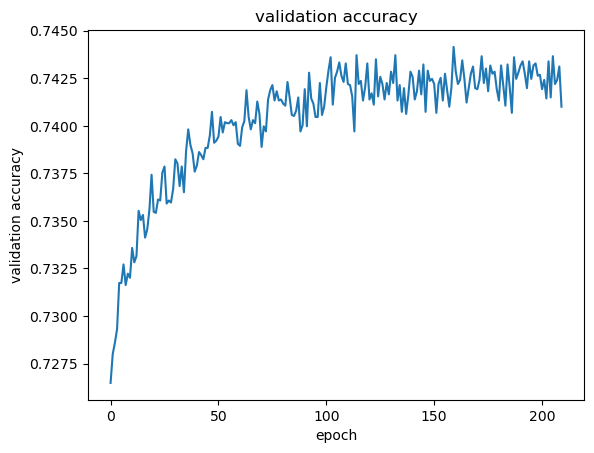

In [247]:
plt.plot(clf.history['val_0_accuracy'][5:])
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.title('validation accuracy')

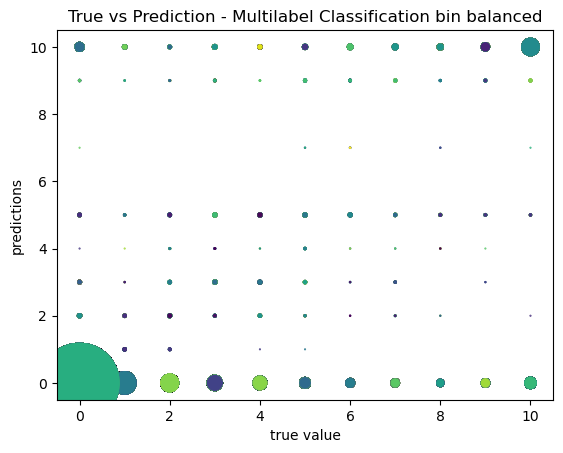

In [248]:
preds = clf.predict(x_test) 
from sklearn.metrics import accuracy_score
# accuracy = accuracy_score(y_test,preds)

# print(f"Accuracy SCORE: {accuracy}")
# print(f"MSE TEST SCORE: {test_mse}")
# print(f"RMSE TEST SCORE: {test_rmse}")
# print(f"MAE TEST SCORE: {test_mae}")

# from sklearn.metrics import r2_score
# score = r2_score(y_test, preds)
# print(score)
# print("The accuracy of our model is {}%".format(round(score, 2) *100))

# y_test
df = pd.DataFrame(preds)
dft = df.T
dft.columns = ['preds']
dft['preds'] = dft['preds'].apply(pd.to_numeric)
dft1= dft.loc[dft['preds'] > 0]
dft = dft.to_numpy()
y_test
colors = np.random.rand(18457)

from collections import Counter
c = Counter(zip(y_test[:, 0],dft[:, 0]))
# create a list of the sizes, here multiplied by 10 for scale
s = [(c[(xx,yy)]/4) for xx,yy in zip(y_test[:, 0],dft[:, 0])]


plt.scatter(y_test[:, 0],dft[:, 0],s=s, c =colors)
plt.xlabel('true value')
plt.ylabel('predictions')
plt.title('True vs Prediction - Multilabel Classification bin balanced')
# To show the plot
plt.show()

0

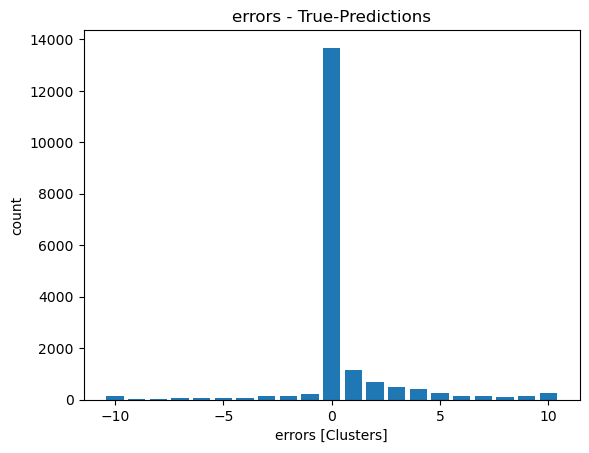

In [249]:
residuals  = y_test[:, 0] - dft[:, 0]
# residuals

# plt.hist(residuals, align='left',color='g', edgecolor='b',linewidth=1)
# plt.xlabel('Residuals: y_true-preds')
# plt.ylabel('Frequency')

error_df = pd.DataFrame(residuals, columns=["error"])
error_df

amount = [error_df['error'].loc[error_df['error']==-10].count(),
          error_df['error'].loc[error_df['error']==-9].count(),
          error_df['error'].loc[error_df['error']==-8].count(),
        error_df['error'].loc[error_df['error']==-7].count(),
         error_df['error'].loc[error_df['error']==-6].count(),
          error_df['error'].loc[error_df['error']==-5].count(),
         error_df['error'].loc[error_df['error']==-4].count(),
         error_df['error'].loc[error_df['error']==-3].count(),
         error_df['error'].loc[error_df['error']==-2].count(),
         error_df['error'].loc[error_df['error']==-1].count(),
         error_df['error'].loc[error_df['error']==0].count(),
         error_df['error'].loc[error_df['error']==1].count(),
          error_df['error'].loc[error_df['error']==2].count(),
        error_df['error'].loc[error_df['error']==3].count(),
         error_df['error'].loc[error_df['error']==4].count(),
          error_df['error'].loc[error_df['error']==5].count(),
         error_df['error'].loc[error_df['error']==6].count(),
         error_df['error'].loc[error_df['error']==7].count(),
         error_df['error'].loc[error_df['error']==8].count(),
         error_df['error'].loc[error_df['error']==9].count(),
         error_df['error'].loc[error_df['error']==10].count()]
data = {'clusters error':[*range(-10, 11, 1)],'amount':amount}
df = pd.DataFrame(data)

plt.bar(x=df['clusters error'],height=df['amount'])
plt.title('errors - True-Predictions')
plt.xlabel('errors [Clusters]')
plt.ylabel('count')

error_df['error'].loc[error_df['error']>10].count()

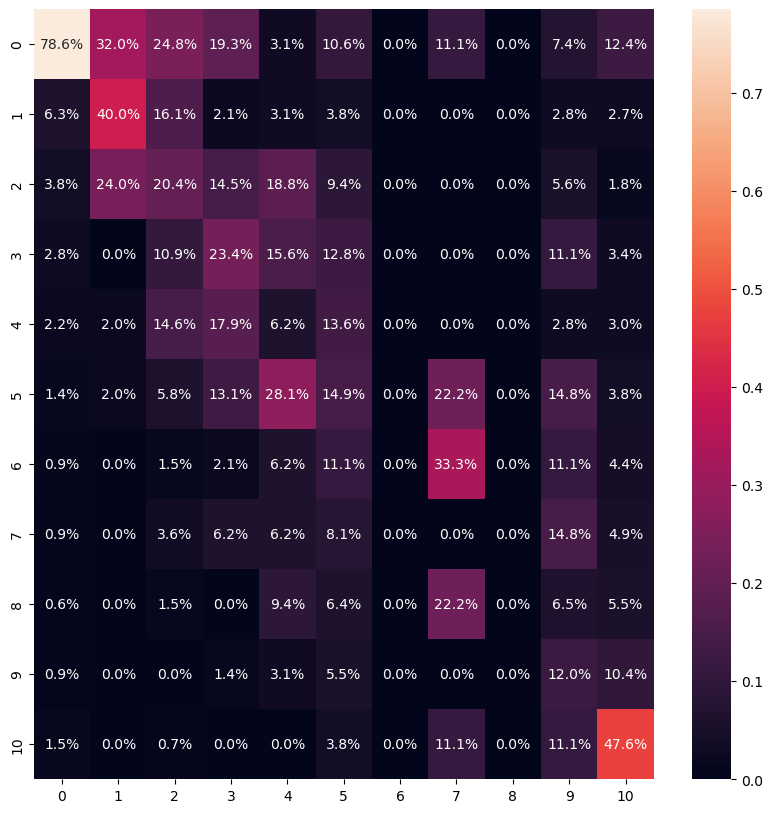

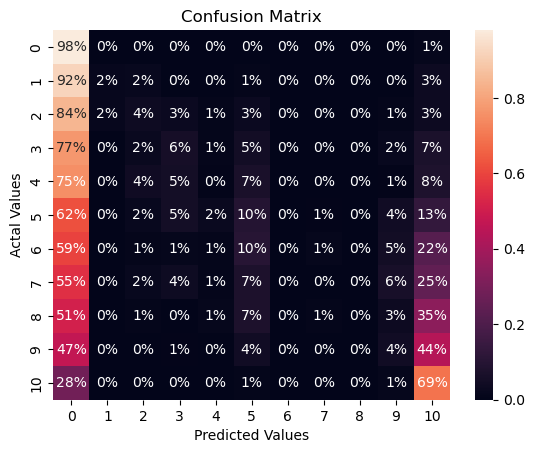

In [250]:
# from sklearn.metrics import confusion_matrix
# np.set_printoptions()
# cm = confusion_matrix(y_test[:, 0],dft[:, 0])
# cm_df = pd.DataFrame(cm,
#                      index = ['0','1','2','3','4','5','6','7','8','9','10'], 
#                      columns = ['0','1','2','3','4','5','6','7','8','9','10'])

# plt.figure(figsize=(10,10))
# cm_perc=(cm_df/np.sum(cm_df)).fillna(0)
# cm_perc

# sns.heatmap(cm_perc, annot=True,fmt='.1%')
# plt.title('Confusion Matrix')
# plt.ylabel('Actal Values')
# plt.xlabel('Predicted Values')
# plt.show()

from sklearn.metrics import confusion_matrix
np.set_printoptions()
cm = confusion_matrix(y_test[:, 0],dft[:, 0])
cm_df = pd.DataFrame(cm,
                     index = ['0','1','2','3','4','5','6','7','8','9','10'], 
                     columns = ['0','1','2','3','4','5','6','7','8','9','10'])

plt.figure(figsize=(10,10))
cm_perc=(cm_df/np.sum(cm_df)).fillna(0)
cm_perc
sns.heatmap(cm_perc, annot=True,fmt='.1%')
plt.show()

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True,fmt='.0%')


plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

# Without Class 0 

In [22]:
grouped_data = pd.read_csv('6dof_classification.csv')
grouped_data = grouped_data.drop(columns='Unnamed: 0')
grouped_data

,Link2 length,Link3 length,Link4 length,Link5 length,Link6 length,Success_Rates,Joint2 type_pitch,Joint2 type_pris,Joint2 type_roll,Joint3 type_pitch,...,Joint3 axis_z,Joint4 axis_x,Joint4 axis_y,Joint4 axis_z,Joint5 axis_x,Joint5 axis_y,Joint5 axis_z,Joint6 axis_x,Joint6 axis_y,Joint6 axis_z
0,0.1,0.1,0.1,0.3,0.7,0,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
1,0.1,0.1,0.1,0.5,0.5,0,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
2,0.1,0.1,0.1,0.7,0.7,0,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
3,0.1,0.1,0.1,0.7,0.7,0,1,0,0,1,...,0,1,0,0,1,0,0,0,1,0
4,0.1,0.1,0.1,0.7,0.7,0,1,0,0,1,...,0,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102535,0.7,0.7,0.3,0.1,0.1,2,0,0,1,0,...,0,0,1,0,1,0,0,0,0,1
102536,0.7,0.7,0.1,0.1,0.3,7,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
102537,0.7,0.7,0.3,0.1,0.1,0,0,0,1,0,...,0,0,0,1,0,1,0,1,0,0
102538,0.7,0.7,0.1,0.1,0.3,10,0,0,1,0,...,0,0,1,0,0,1,0,1,0,0


In [23]:
no_sucsses = grouped_data.loc[grouped_data['Success_Rates']==0]
yes_sucsses = grouped_data.loc[grouped_data['Success_Rates']>0]
yes_sucsses

,Link2 length,Link3 length,Link4 length,Link5 length,Link6 length,Success_Rates,Joint2 type_pitch,Joint2 type_pris,Joint2 type_roll,Joint3 type_pitch,...,Joint3 axis_z,Joint4 axis_x,Joint4 axis_y,Joint4 axis_z,Joint5 axis_x,Joint5 axis_y,Joint5 axis_z,Joint6 axis_x,Joint6 axis_y,Joint6 axis_z
10,0.1,0.1,0.1,0.5,0.5,1,1,0,0,1,...,0,1,0,0,0,1,0,0,0,1
15,0.1,0.1,0.1,0.7,0.5,1,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
23,0.1,0.1,0.3,0.7,0.1,2,1,0,0,1,...,0,1,0,0,0,0,1,0,1,0
34,0.1,0.1,0.5,0.5,0.7,3,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
47,0.1,0.1,0.5,0.5,0.1,1,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102534,0.7,0.7,0.1,0.1,0.3,10,0,0,1,0,...,0,0,1,0,0,0,1,0,1,0
102535,0.7,0.7,0.3,0.1,0.1,2,0,0,1,0,...,0,0,1,0,1,0,0,0,0,1
102536,0.7,0.7,0.1,0.1,0.3,7,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
102538,0.7,0.7,0.1,0.1,0.3,10,0,0,1,0,...,0,0,1,0,0,1,0,1,0,0


In [24]:
X = yes_sucsses.loc[:,yes_sucsses.columns != 'Success_Rates']
Y = yes_sucsses.loc[:,yes_sucsses.columns == 'Success_Rates']
X=X.to_numpy()
X = [[float(j) for j in i] for i in X]
X=np.array(X)
Y=Y.to_numpy()



x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.25, random_state=2)
    
    
print("x train\n", x_train.shape)
print("y train\n", y_train.shape)

print("x valid\n", x_valid.shape)
print("y valid\n", y_valid.shape)

print("x test\n", x_test.shape)
print("y test\n", y_test.shape)


x train
 (17628, 34)
y train
 (17628, 1)
x valid
 (5876, 34)
y valid
 (5876, 1)
x test
 (5877, 34)
y test
 (5877, 1)


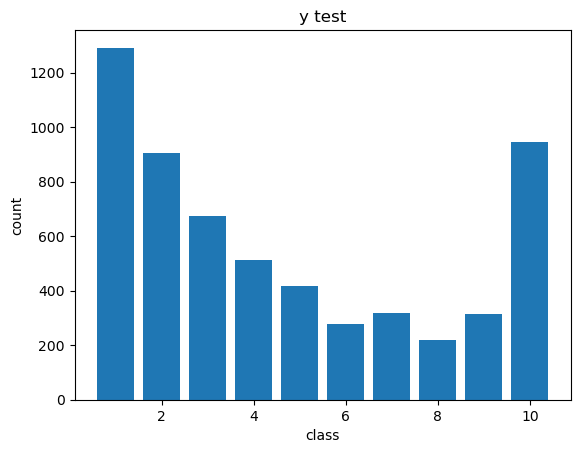

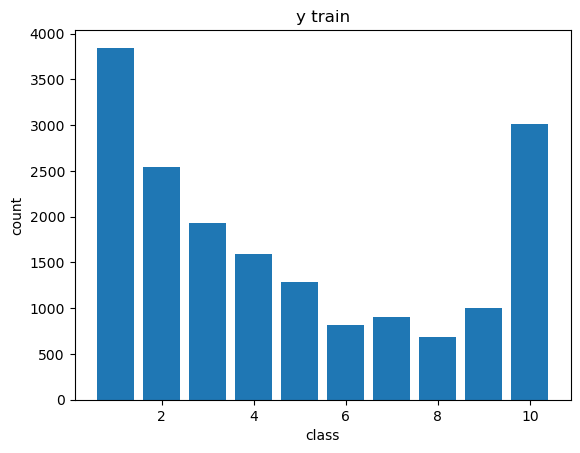

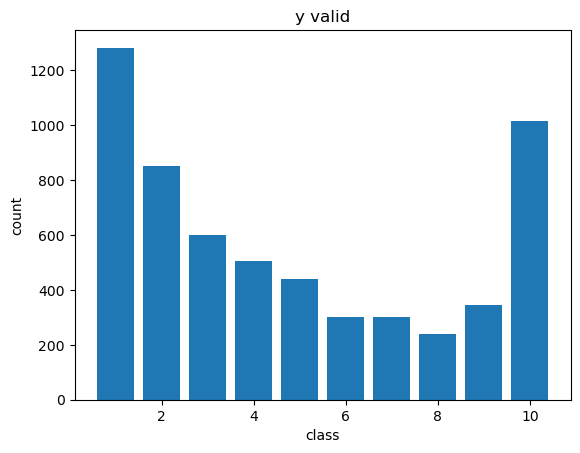

a (array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([1291,  905,  673,  514,  416,  279,  318,  220,  315,  946]))
b (array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([3845, 2546, 1925, 1593, 1289,  817,  909,  686, 1004, 3014]))
c (array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([1282,  853,  600,  504,  438,  301,  302,  238,  344, 1014]))


In [25]:
a = np.unique(np.squeeze(y_test), return_counts=True)
plt.bar(x=a[0],height=a[1])
plt.title('y test')
plt.xlabel('class')
plt.ylabel('count')
plt.show()

b = np.unique(np.squeeze(y_train), return_counts=True)
plt.bar(x=b[0],height=b[1])
plt.title('y train')
plt.xlabel('class')
plt.ylabel('count')

plt.show()

c = np.unique(np.squeeze(y_valid), return_counts=True)
plt.bar(x=c[0],height=c[1])
plt.title('y valid')
plt.xlabel('class')
plt.ylabel('count')
plt.show()

print('a',a)
print('b',b)
print('c',c)

In [26]:
clf = TabNetMultiTaskClassifier(n_steps=1,
                                optimizer_fn=torch.optim.Adam,
                                optimizer_params=dict(lr=2e-2),
                                scheduler_params={"step_size":50, # how to use learning rate scheduler
                                                  "gamma":0.9},
                                scheduler_fn=torch.optim.lr_scheduler.StepLR,
                                mask_type='entmax', # "sparsemax",
                                lambda_sparse=0, # don't penalize for sparser attention
                       
                      )

Device used : cpu


In [27]:
max_epochs = 1000
clf.fit(
    X_train=x_train, y_train=y_train,
    eval_set=[(x_valid, y_valid)],
    eval_metric=['accuracy'],
    max_epochs=max_epochs ,
    patience=50, # please be patient ^^
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=1,
    drop_last=False,
)

epoch 0  | loss: 2.24444 | val_0_accuracy: 0.21715 |  0:00:00s
epoch 1  | loss: 2.13061 | val_0_accuracy: 0.23451 |  0:00:00s
epoch 2  | loss: 2.07449 | val_0_accuracy: 0.27263 |  0:00:01s
epoch 3  | loss: 2.02487 | val_0_accuracy: 0.2808  |  0:00:01s
epoch 4  | loss: 1.98337 | val_0_accuracy: 0.28965 |  0:00:02s
epoch 5  | loss: 1.95397 | val_0_accuracy: 0.29816 |  0:00:02s
epoch 6  | loss: 1.92992 | val_0_accuracy: 0.29765 |  0:00:03s
epoch 7  | loss: 1.91425 | val_0_accuracy: 0.3014  |  0:00:03s
epoch 8  | loss: 1.89966 | val_0_accuracy: 0.30973 |  0:00:03s
epoch 9  | loss: 1.89057 | val_0_accuracy: 0.32097 |  0:00:04s
epoch 10 | loss: 1.87786 | val_0_accuracy: 0.31246 |  0:00:04s
epoch 11 | loss: 1.86381 | val_0_accuracy: 0.32012 |  0:00:05s
epoch 12 | loss: 1.85631 | val_0_accuracy: 0.31739 |  0:00:05s
epoch 13 | loss: 1.84984 | val_0_accuracy: 0.32046 |  0:00:05s
epoch 14 | loss: 1.84693 | val_0_accuracy: 0.33713 |  0:00:06s
epoch 15 | loss: 1.84061 | val_0_accuracy: 0.33901 |  0

epoch 131| loss: 1.63165 | val_0_accuracy: 0.36675 |  0:00:55s
epoch 132| loss: 1.64089 | val_0_accuracy: 0.36947 |  0:00:56s
epoch 133| loss: 1.63338 | val_0_accuracy: 0.36998 |  0:00:56s
epoch 134| loss: 1.63785 | val_0_accuracy: 0.3676  |  0:00:56s
epoch 135| loss: 1.6431  | val_0_accuracy: 0.36607 |  0:00:57s
epoch 136| loss: 1.63649 | val_0_accuracy: 0.36964 |  0:00:57s
epoch 137| loss: 1.63798 | val_0_accuracy: 0.36998 |  0:00:58s
epoch 138| loss: 1.63244 | val_0_accuracy: 0.36964 |  0:00:58s
epoch 139| loss: 1.6403  | val_0_accuracy: 0.37321 |  0:00:58s
epoch 140| loss: 1.63421 | val_0_accuracy: 0.37253 |  0:00:59s
epoch 141| loss: 1.63975 | val_0_accuracy: 0.3659  |  0:00:59s
epoch 142| loss: 1.62786 | val_0_accuracy: 0.37168 |  0:01:00s
epoch 143| loss: 1.63229 | val_0_accuracy: 0.36147 |  0:01:00s
epoch 144| loss: 1.63777 | val_0_accuracy: 0.37185 |  0:01:00s
epoch 145| loss: 1.63198 | val_0_accuracy: 0.36504 |  0:01:01s
epoch 146| loss: 1.632   | val_0_accuracy: 0.36981 |  0

Text(0.5, 1.0, 'validation accuracy')

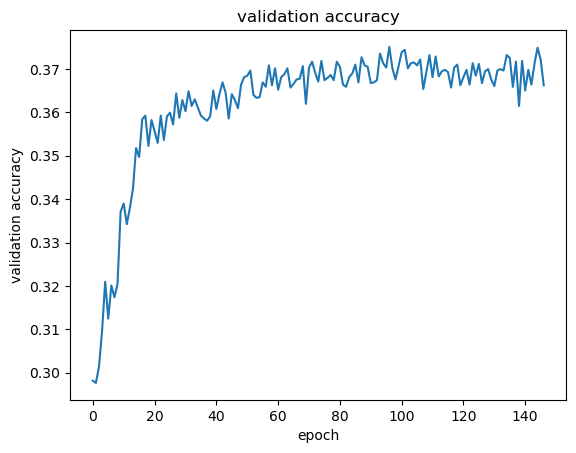

In [28]:
plt.plot(clf.history['val_0_accuracy'][5:])
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.title('validation accuracy')

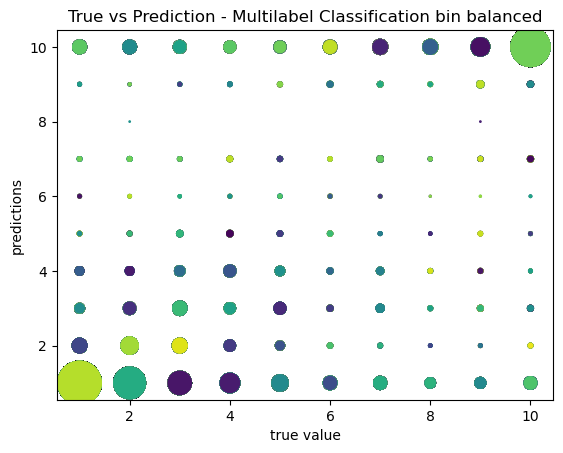

In [29]:
preds = clf.predict(x_test) 
from sklearn.metrics import accuracy_score
# accuracy = accuracy_score(y_test,preds)

# print(f"Accuracy SCORE: {accuracy}")
# print(f"MSE TEST SCORE: {test_mse}")
# print(f"RMSE TEST SCORE: {test_rmse}")
# print(f"MAE TEST SCORE: {test_mae}")

# from sklearn.metrics import r2_score
# score = r2_score(y_test, preds)
# print(score)
# print("The accuracy of our model is {}%".format(round(score, 2) *100))

# y_test
df = pd.DataFrame(preds)
dft = df.T
dft.columns = ['preds']
dft['preds'] = dft['preds'].apply(pd.to_numeric)
dft1= dft.loc[dft['preds'] > 0]
dft = dft.to_numpy()
y_test
colors = np.random.rand(5877)

from collections import Counter
c = Counter(zip(y_test[:, 0],dft[:, 0]))
# create a list of the sizes, here multiplied by 10 for scale
s = [(c[(xx,yy)]) for xx,yy in zip(y_test[:, 0],dft[:, 0])]


plt.scatter(y_test[:, 0],dft[:, 0],s=s, c =colors)
plt.xlabel('true value')
plt.ylabel('predictions')
plt.title('True vs Prediction - Multilabel Classification bin balanced')
# To show the plot
plt.show()

Text(0, 0.5, 'count')

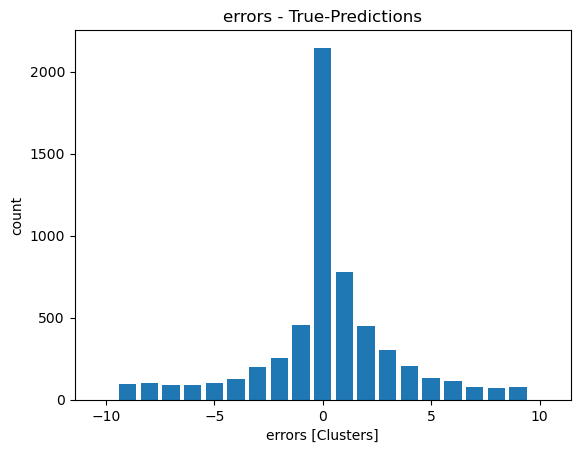

In [30]:
residuals  = y_test[:, 0] - dft[:, 0]
# residuals

# plt.hist(residuals, align='left',color='g', edgecolor='b',linewidth=1)
# plt.xlabel('Residuals: y_true-preds')
# plt.ylabel('Frequency')
error_df = pd.DataFrame(residuals, columns=["error"])
error_df

amount = [error_df['error'].loc[error_df['error']==-10].count(),
          error_df['error'].loc[error_df['error']==-9].count(),
          error_df['error'].loc[error_df['error']==-8].count(),
        error_df['error'].loc[error_df['error']==-7].count(),
         error_df['error'].loc[error_df['error']==-6].count(),
          error_df['error'].loc[error_df['error']==-5].count(),
         error_df['error'].loc[error_df['error']==-4].count(),
         error_df['error'].loc[error_df['error']==-3].count(),
         error_df['error'].loc[error_df['error']==-2].count(),
         error_df['error'].loc[error_df['error']==-1].count(),
         error_df['error'].loc[error_df['error']==0].count(),
         error_df['error'].loc[error_df['error']==1].count(),
          error_df['error'].loc[error_df['error']==2].count(),
        error_df['error'].loc[error_df['error']==3].count(),
         error_df['error'].loc[error_df['error']==4].count(),
          error_df['error'].loc[error_df['error']==5].count(),
         error_df['error'].loc[error_df['error']==6].count(),
         error_df['error'].loc[error_df['error']==7].count(),
         error_df['error'].loc[error_df['error']==8].count(),
         error_df['error'].loc[error_df['error']==9].count(),
         error_df['error'].loc[error_df['error']==10].count()]
data = {'clusters error':[*range(-10, 11, 1)],'amount':amount}
df = pd.DataFrame(data)

plt.bar(x=df['clusters error'],height=df['amount'])
plt.title('errors - True-Predictions')
plt.xlabel('errors [Clusters]')
plt.ylabel('count')

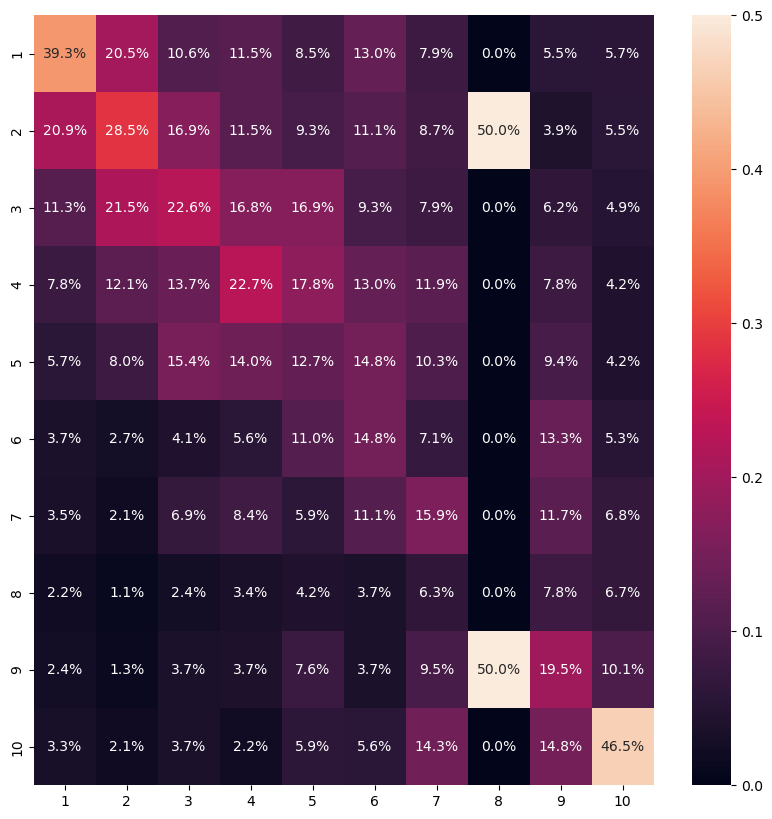

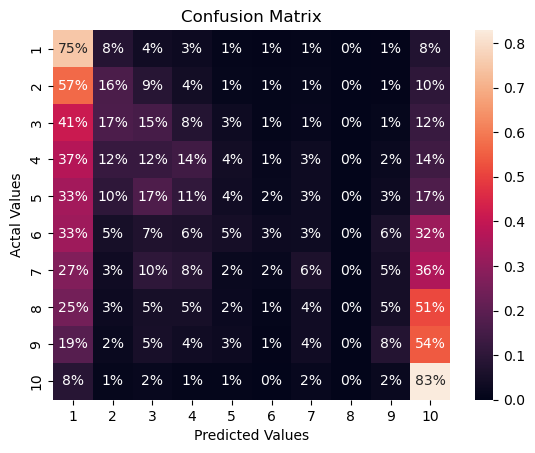

In [31]:
# from sklearn.metrics import confusion_matrix
# np.set_printoptions()
# cm = confusion_matrix(y_test[:, 0],dft[:, 0])
# cm_df = pd.DataFrame(cm,
#                      index = ['1','2','3','4','5','6','7','8','9','10'], 
#                      columns = ['1','2','3','4','5','6','7','8','9','10'])

# plt.figure(figsize=(10,10))
# cm_perc=(cm_df/np.sum(cm_df)).fillna(0)
# cm_perc

# sns.heatmap(cm_perc, annot=True,fmt='.1%')
# plt.title('Confusion Matrix')
# plt.ylabel('Actal Values')
# plt.xlabel('Predicted Values')
# plt.show()

# from sklearn.metrics import confusion_matrix
# np.set_printoptions()
# cm = confusion_matrix(y_test[:, 0],dft[:, 0])
# cm_df = pd.DataFrame(cm,
#                      index = ['0','1','2','3','4','5','6','7','8','9','10'], 
#                      columns = ['0','1','2','3','4','5','6','7','8','9','10'])

# plt.figure(figsize=(10,10))
# cm_perc=(cm_df/np.sum(cm_df)).fillna(0)
# cm_perc

# sns.heatmap(cm_perc, annot=True,fmt='.1%')
# plt.title('Confusion Matrix')
# plt.ylabel('Actal Values')
# plt.xlabel('Predicted Values')
# plt.show()

from sklearn.metrics import confusion_matrix
np.set_printoptions()
cm = confusion_matrix(y_test[:, 0],dft[:, 0])
cm_df = pd.DataFrame(cm,
                     index = ['1','2','3','4','5','6','7','8','9','10'], 
                     columns = ['1','2','3','4','5','6','7','8','9','10'])

plt.figure(figsize=(10,10))
cm_perc=(cm_df/np.sum(cm_df)).fillna(0)
cm_perc
sns.heatmap(cm_perc, annot=True,fmt='.1%')
plt.show()

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

cm_normalized_df = pd.DataFrame(cm_normalized,
                     index = ['1','2','3','4','5','6','7','8','9','10'], 
                     columns = ['1','2','3','4','5','6','7','8','9','10'])
sns.heatmap(cm_normalized_df, annot=True,fmt='.0%')


plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
# plt.xlim(1,10)
# plt.ylim(1,10)
plt.show()
